In [1]:
import sys
sys.path.append("../../")

In [2]:
import random
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1 import make_axes_locatable
from botorch.utils.sampling import draw_sobol_samples
from botorch.utils.multi_objective.pareto import is_non_dominated
from botorch.test_functions.multi_objective import GMM, BraninCurrin
from botorch.utils.multi_objective.box_decompositions.dominated import DominatedPartitioning
from botorch.utils.multi_objective.box_decompositions.non_dominated import FastNondominatedPartitioning


tkwargs = {
    "dtype": torch.double,
    "device": torch.device("cpu"),
}
SEED = 42
# Setting seed for reproducibility
random.seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)

In [3]:
# define problem
# problem = BraninCurrin(negate=True).to(**tkwargs)
problem = GMM(negate=True).to(**tkwargs)
problem.ref_point = torch.tensor([0., 0.], **tkwargs)

## Problem

The approximated pareto set and pareto front is shown in the following figure.

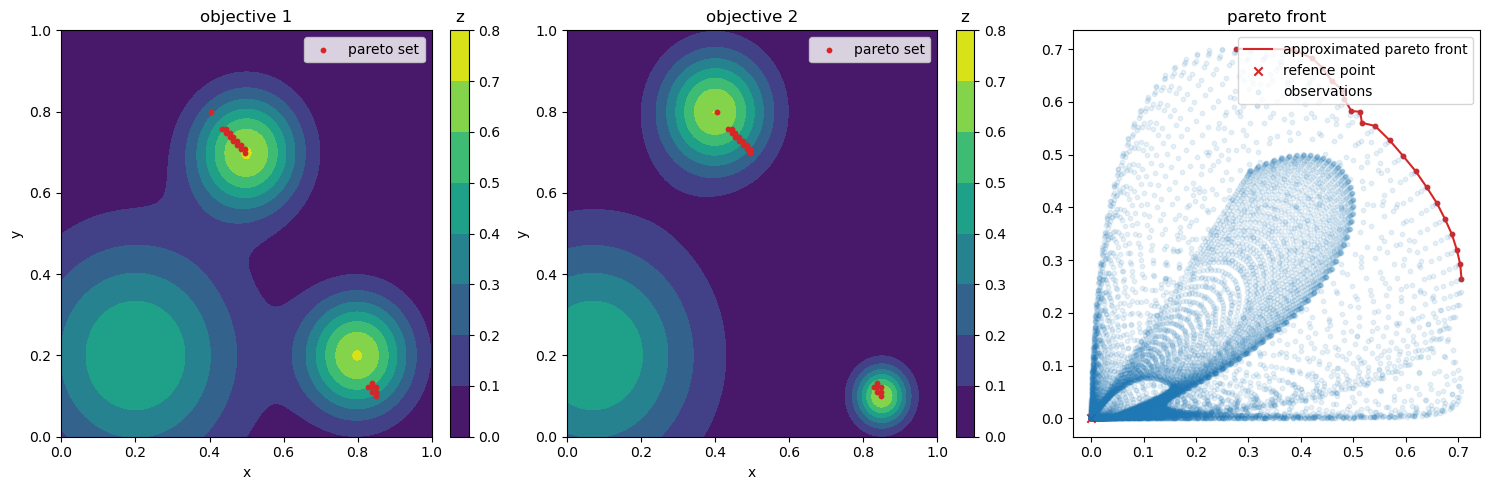

In [4]:
from plot_utils import plot_objective

plot_objective(problem, num_samples=100)

In [5]:
def generate_initial_data(problem, n=6):
    # generate training data
    train_x = draw_sobol_samples(bounds=problem.bounds, n=n, q=1).squeeze(1)
    train_obj = problem(train_x)
    return train_x, train_obj

In [6]:
init_x, init_y = generate_initial_data(problem, n=6)

## Generate data

In [7]:
from optimizers.qehvi.qehvi import qEHVI

In [8]:
def plot_input_space(xx, yy, x_obs, preds, fig, ax, title=None):
    div = make_axes_locatable(ax)
    cax = div.append_axes('right', '5%', '5%')

    # plot functions
    countourset = ax.contourf(
        xx,
        yy,
        preds.reshape(xx.shape),
    )
    ax.scatter(*x_obs.t(), alpha=0.3, s=10, color='tab:red')

    cax.grid(False)  # just to remove the warning
    clb = fig.colorbar(countourset, cax=cax)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_title(title)
    clb.ax.set_title('z')


def plot_pareto_space(y_obs, pareto, l, u_nbd, ax, title='pareto'):
    ax.scatter(*y_obs[~pareto].t(), s=10, alpha=0.3)
    ax.scatter(*l.t(), s=10, color='tab:red', label="pareto")
    ax.plot(*l.t(), color='tab:red')
    # ax.scatter(*u_nbd.t(), s=10, label="non dominated", color='tab:purple')
    ax.scatter(*problem.ref_point.t(), s=10, color='k', label="ref point")

    ax.set_xlabel('y1')
    ax.set_ylabel('y2')
    ax.set_title(title)
    ax.legend()


def plot_pareto_box(tau, boxes, ax):
    ax.scatter(*tau.t(), label=r"$\mathbf{\tau}$")
    pc = PatchCollection(boxes, cmap='tab10', alpha=.3)
    pc.set_array(torch.arange(0, len(boxes)))
    ax.add_collection(pc)
    x_lim = ax.get_xlim()
    y_lim = ax.get_ylim()
    ax.axvspan(x_lim[0], tau[0], alpha=0.1, color='tab:gray')
    ax.axhspan(y_lim[0], tau[1], alpha=0.1, color='tab:gray')
    ax.set_xlim(*x_lim)
    ax.set_ylim(*y_lim)

In [9]:
x_obs = init_x
y_obs = init_y
num_samples = 100

num_obj = problem.num_objectives
# only plot the first two dimensions
xx, yy = np.meshgrid(
    np.linspace(
        *problem.bounds.t()[0], num_samples
    ),
    np.linspace(
        *problem.bounds.t()[1], num_samples
    ),
)
x_cands = np.vstack((xx.flatten(), yy.flatten())).T
x_cands = torch.from_numpy(x_cands).to(**tkwargs)
y_cands = problem(x_cands).reshape(num_samples, num_samples, num_obj)
xx_obj, yy_obj = y_cands[:, :, 0], y_cands[:, :, 1]

2024-05-07 10:01:34,722 | qEHVI
2024-05-07 10:01:34,790 | Model fitting takes 0.07s


Iteration 0


2024-05-07 10:01:35,468 | Optimizing the acquisition function takes 0.67s


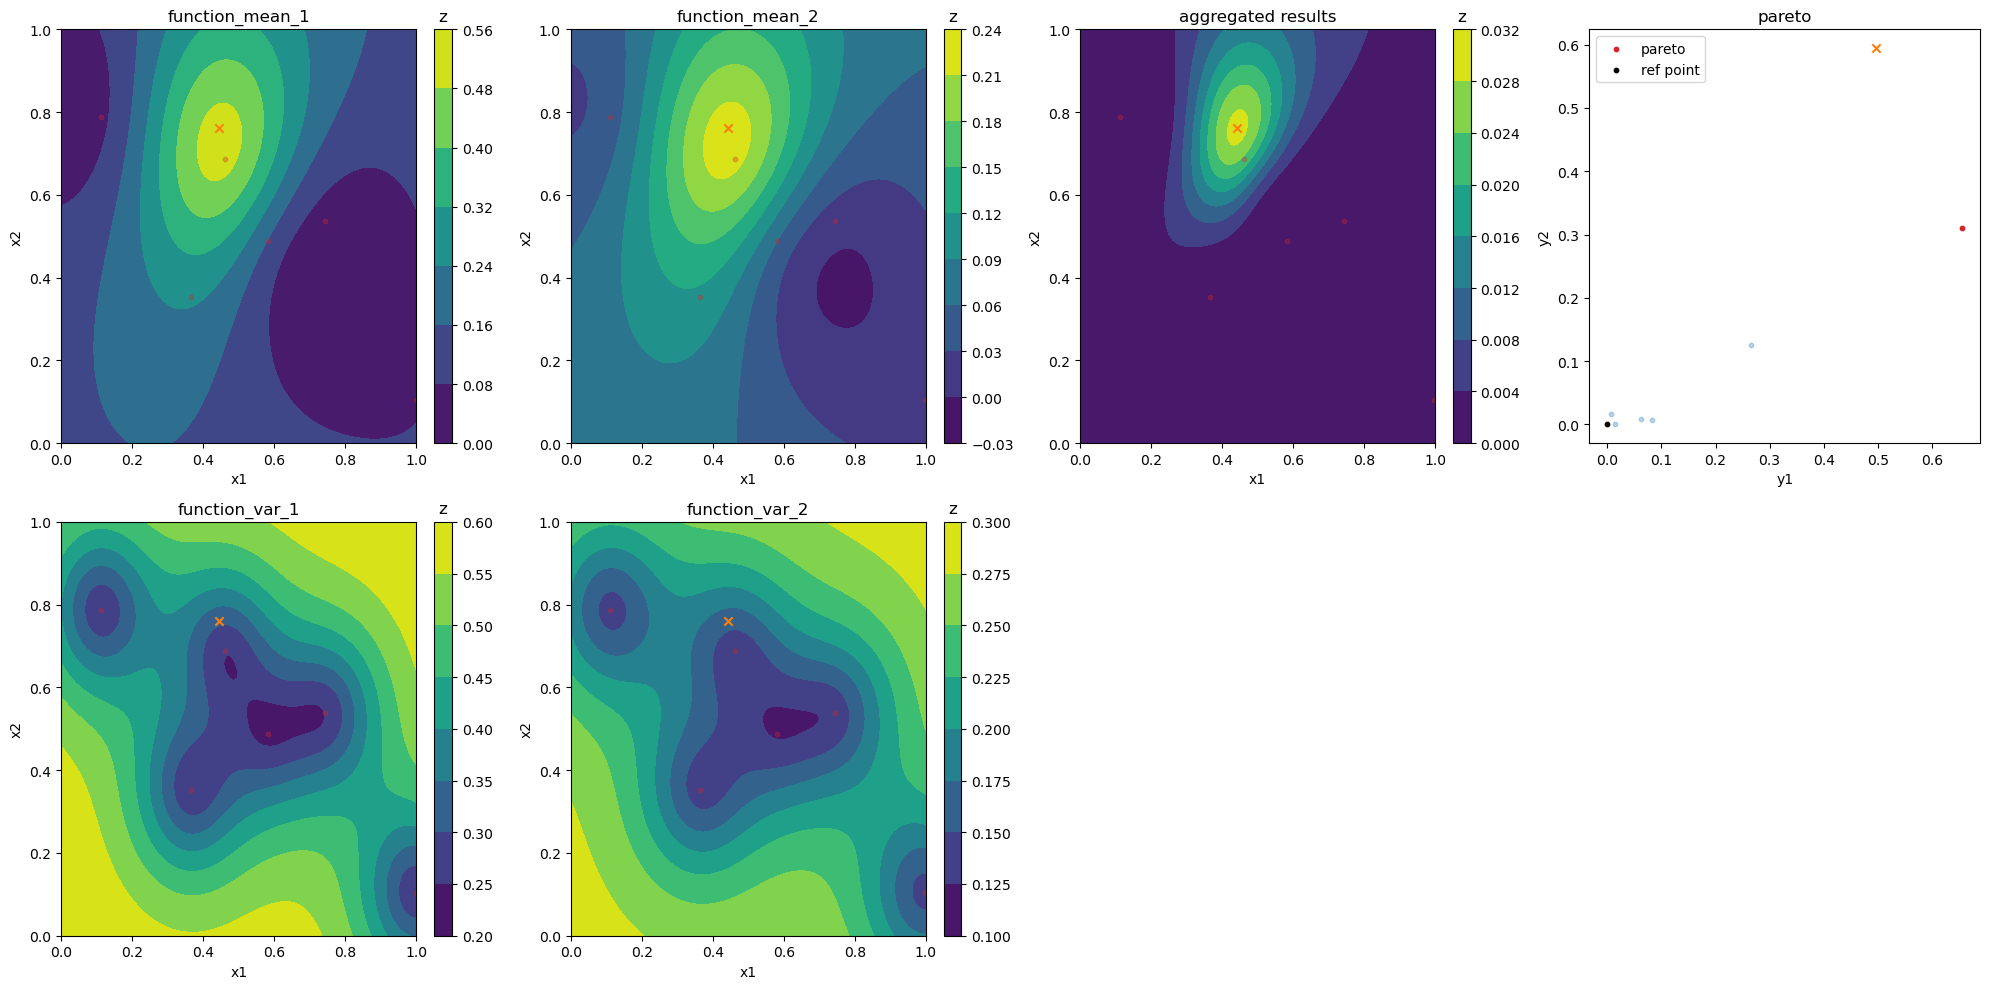

2024-05-07 10:01:36,665 | Model fitting takes 0.07s


Iteration 1


2024-05-07 10:01:37,100 | Optimizing the acquisition function takes 0.43s


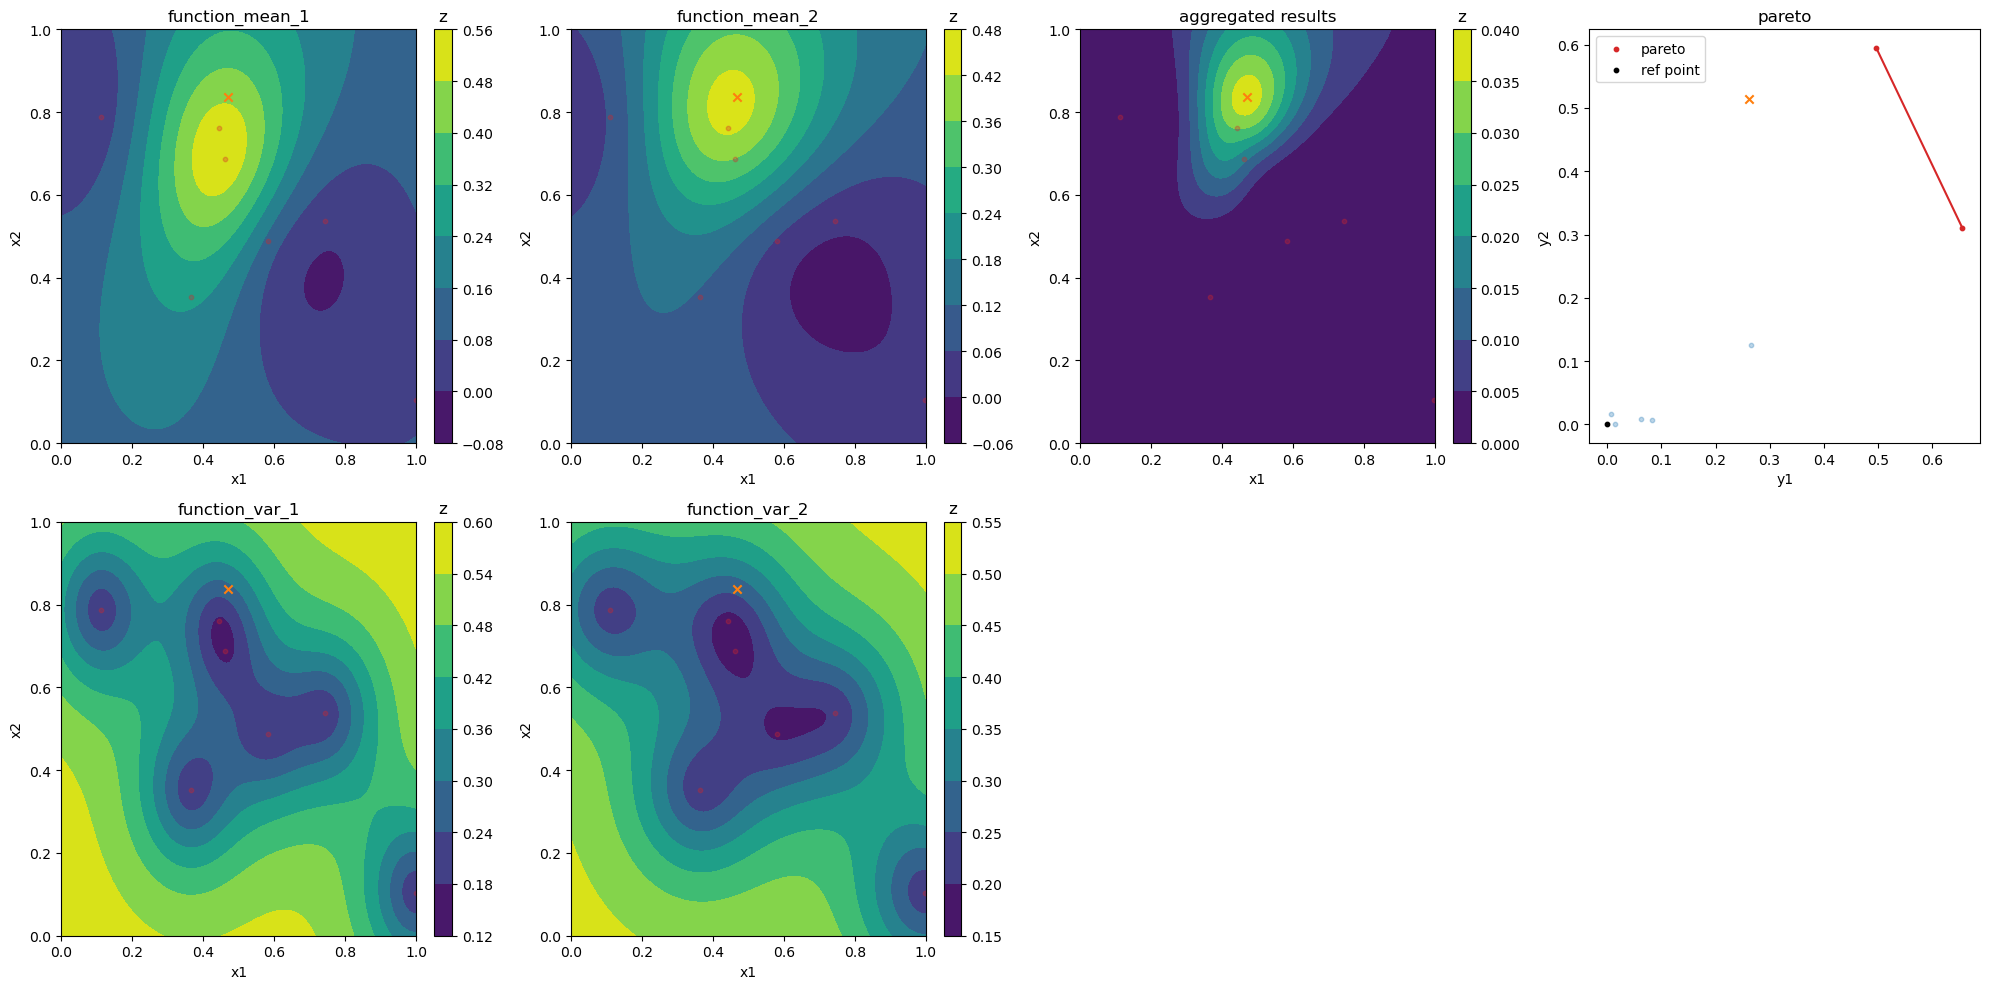

2024-05-07 10:01:38,495 | Model fitting takes 0.10s


Iteration 2


2024-05-07 10:01:39,461 | Optimizing the acquisition function takes 0.96s


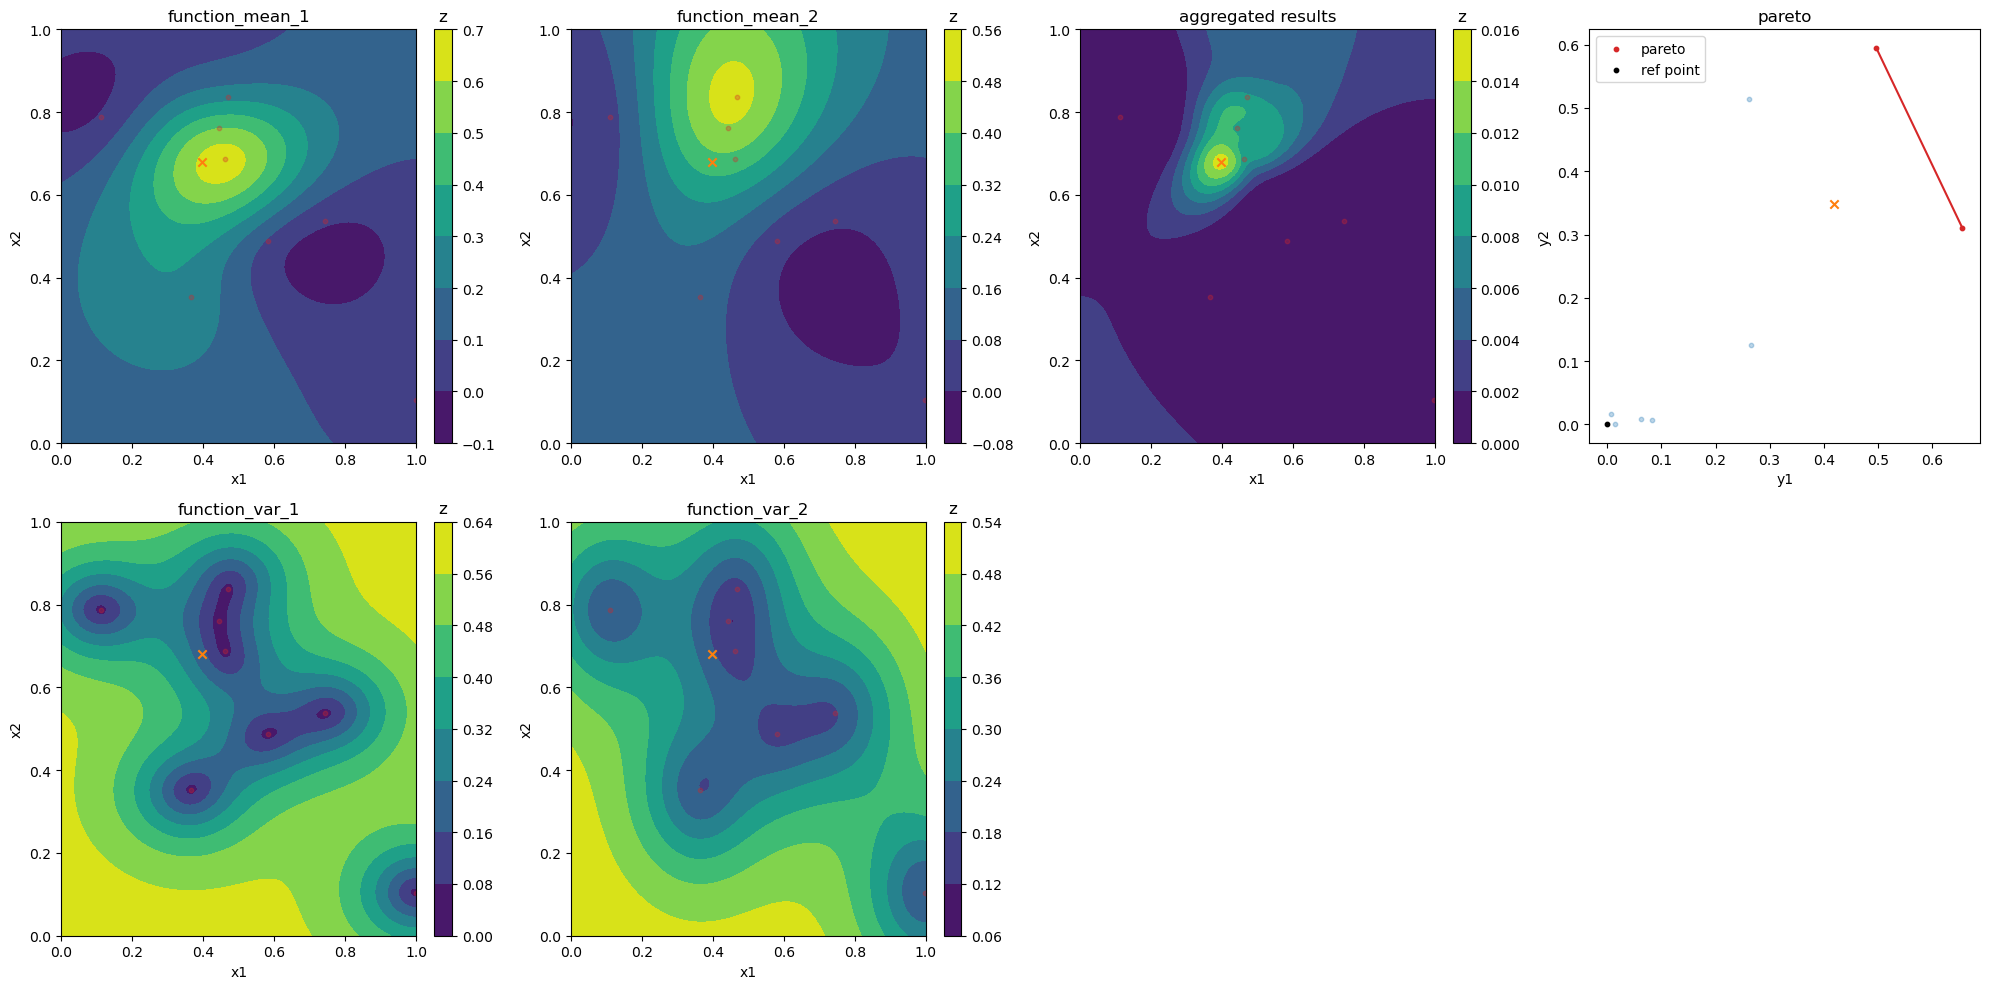

2024-05-07 10:01:40,684 | Model fitting takes 0.10s


Iteration 3


2024-05-07 10:01:41,751 | Optimizing the acquisition function takes 1.06s


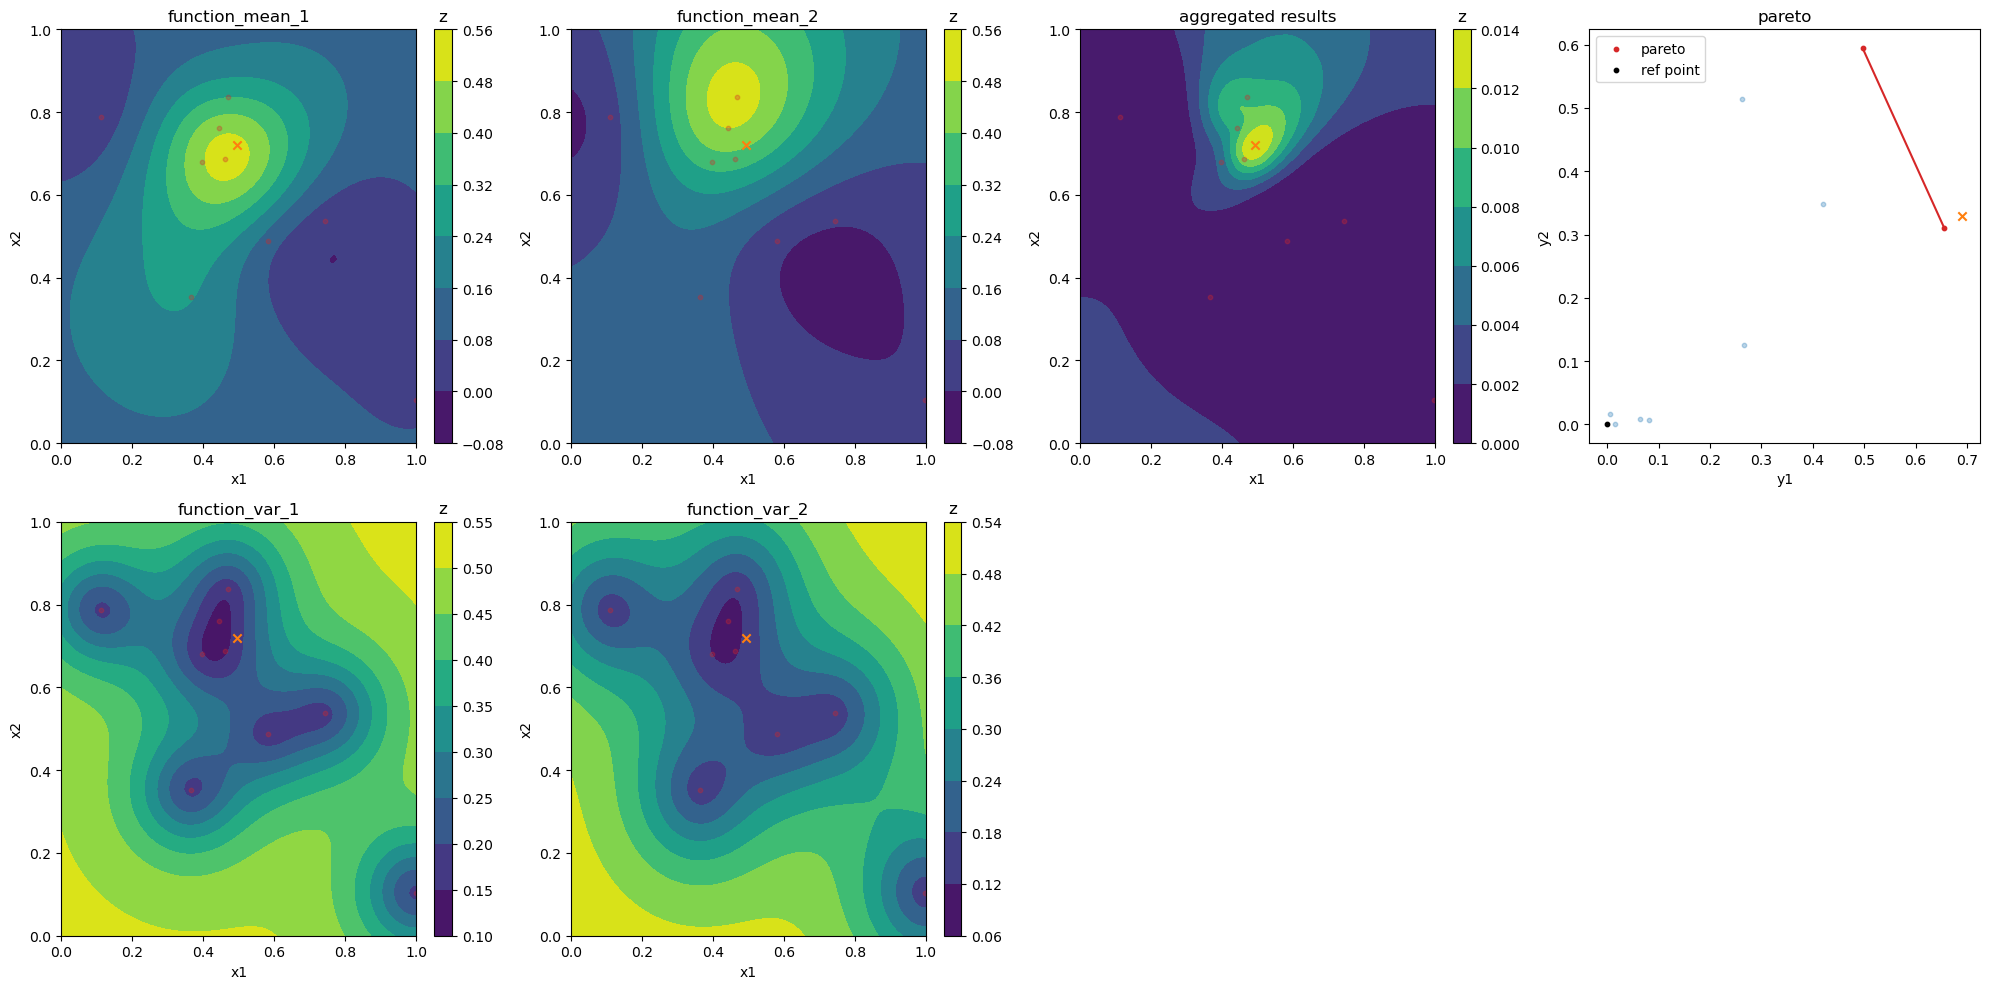

2024-05-07 10:01:43,022 | Model fitting takes 0.14s


Iteration 4


2024-05-07 10:01:43,733 | Optimizing the acquisition function takes 0.71s


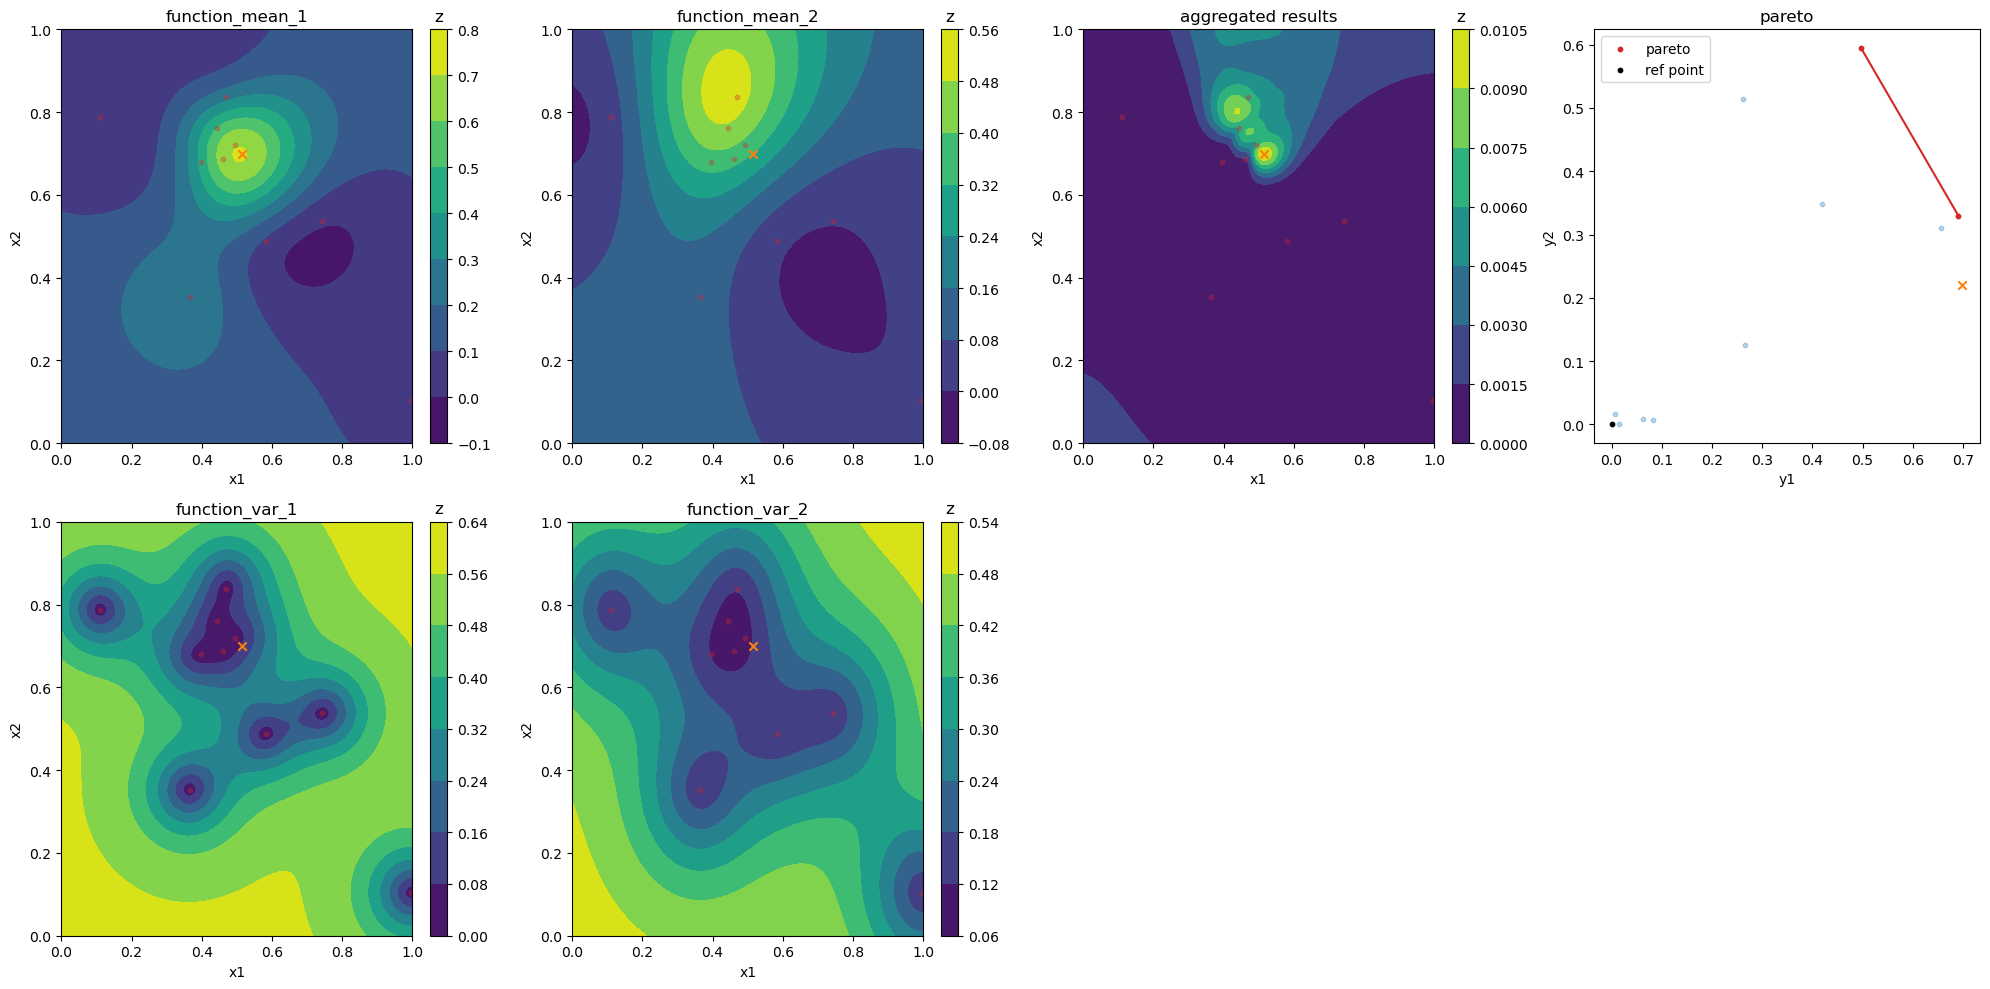

2024-05-07 10:01:45,242 | Model fitting takes 0.19s


Iteration 5


2024-05-07 10:01:45,826 | Optimizing the acquisition function takes 0.58s


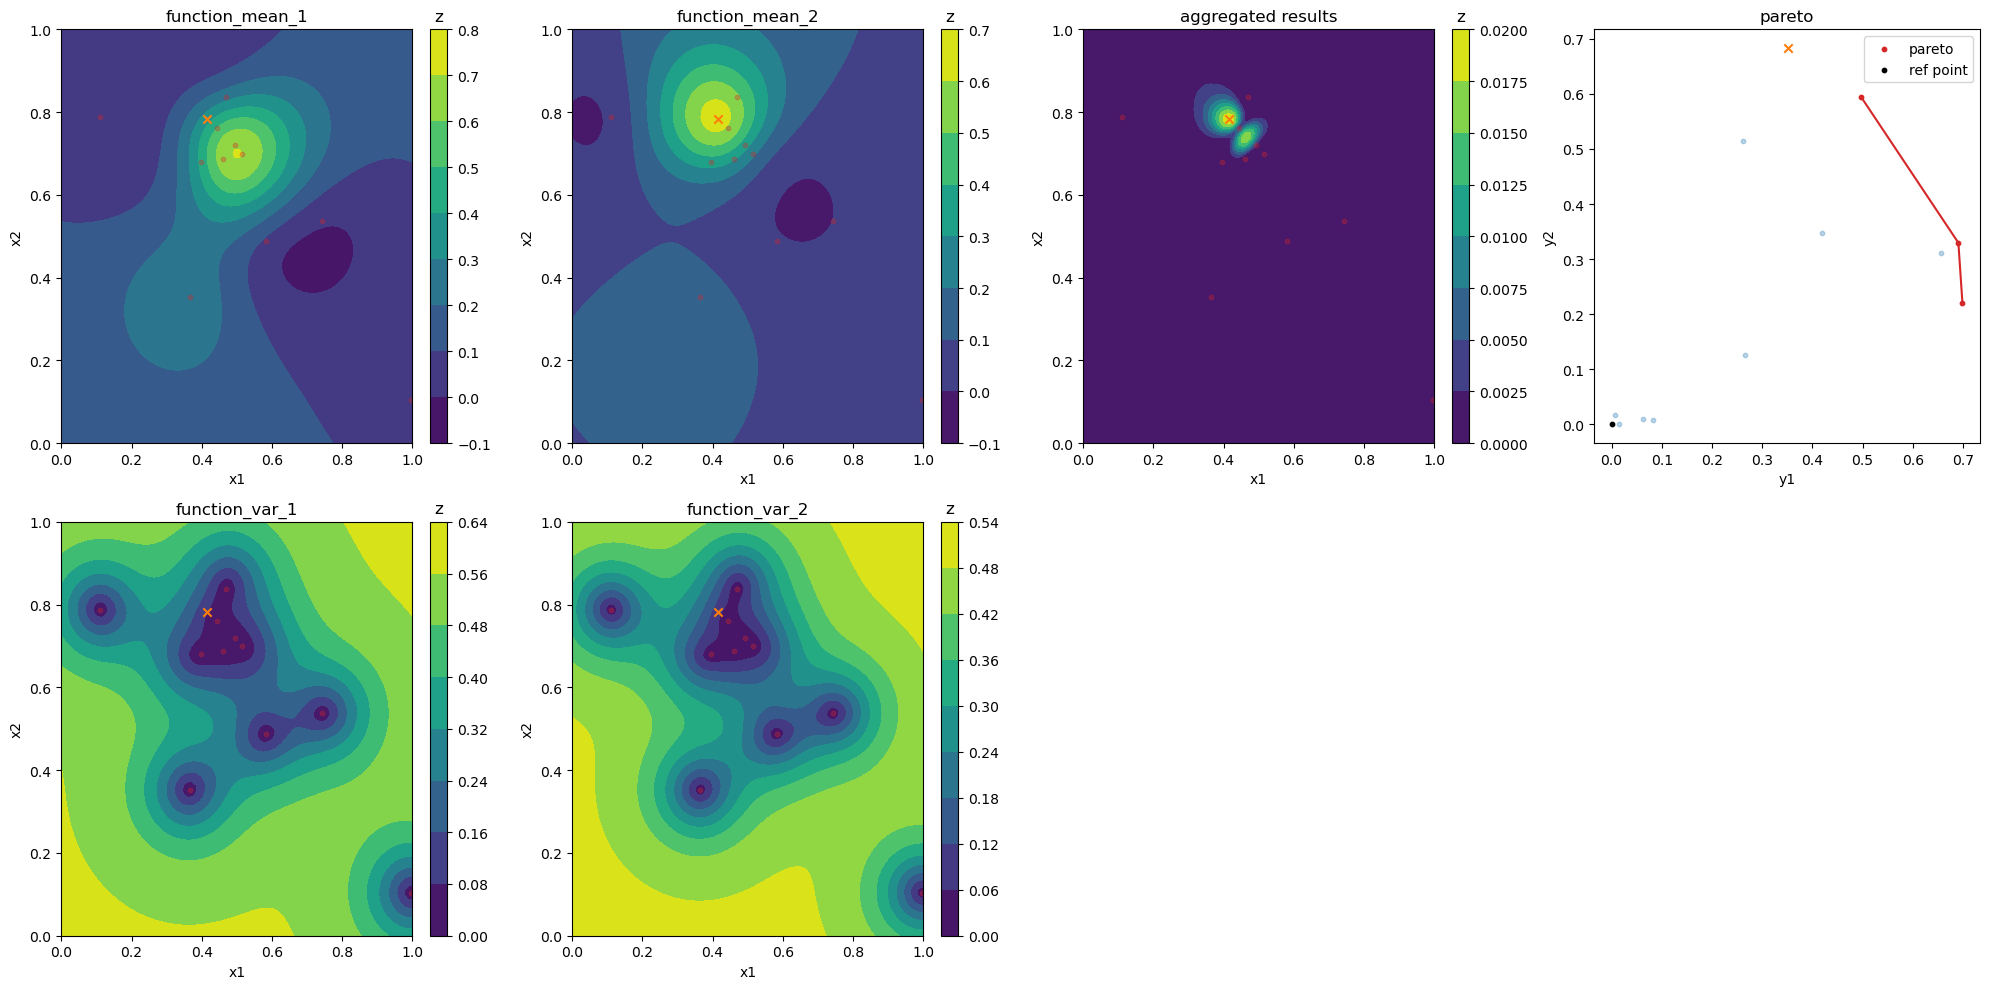

Iteration 6


2024-05-07 10:01:47,250 | Model fitting takes 0.26s
2024-05-07 10:01:48,206 | Optimizing the acquisition function takes 0.95s


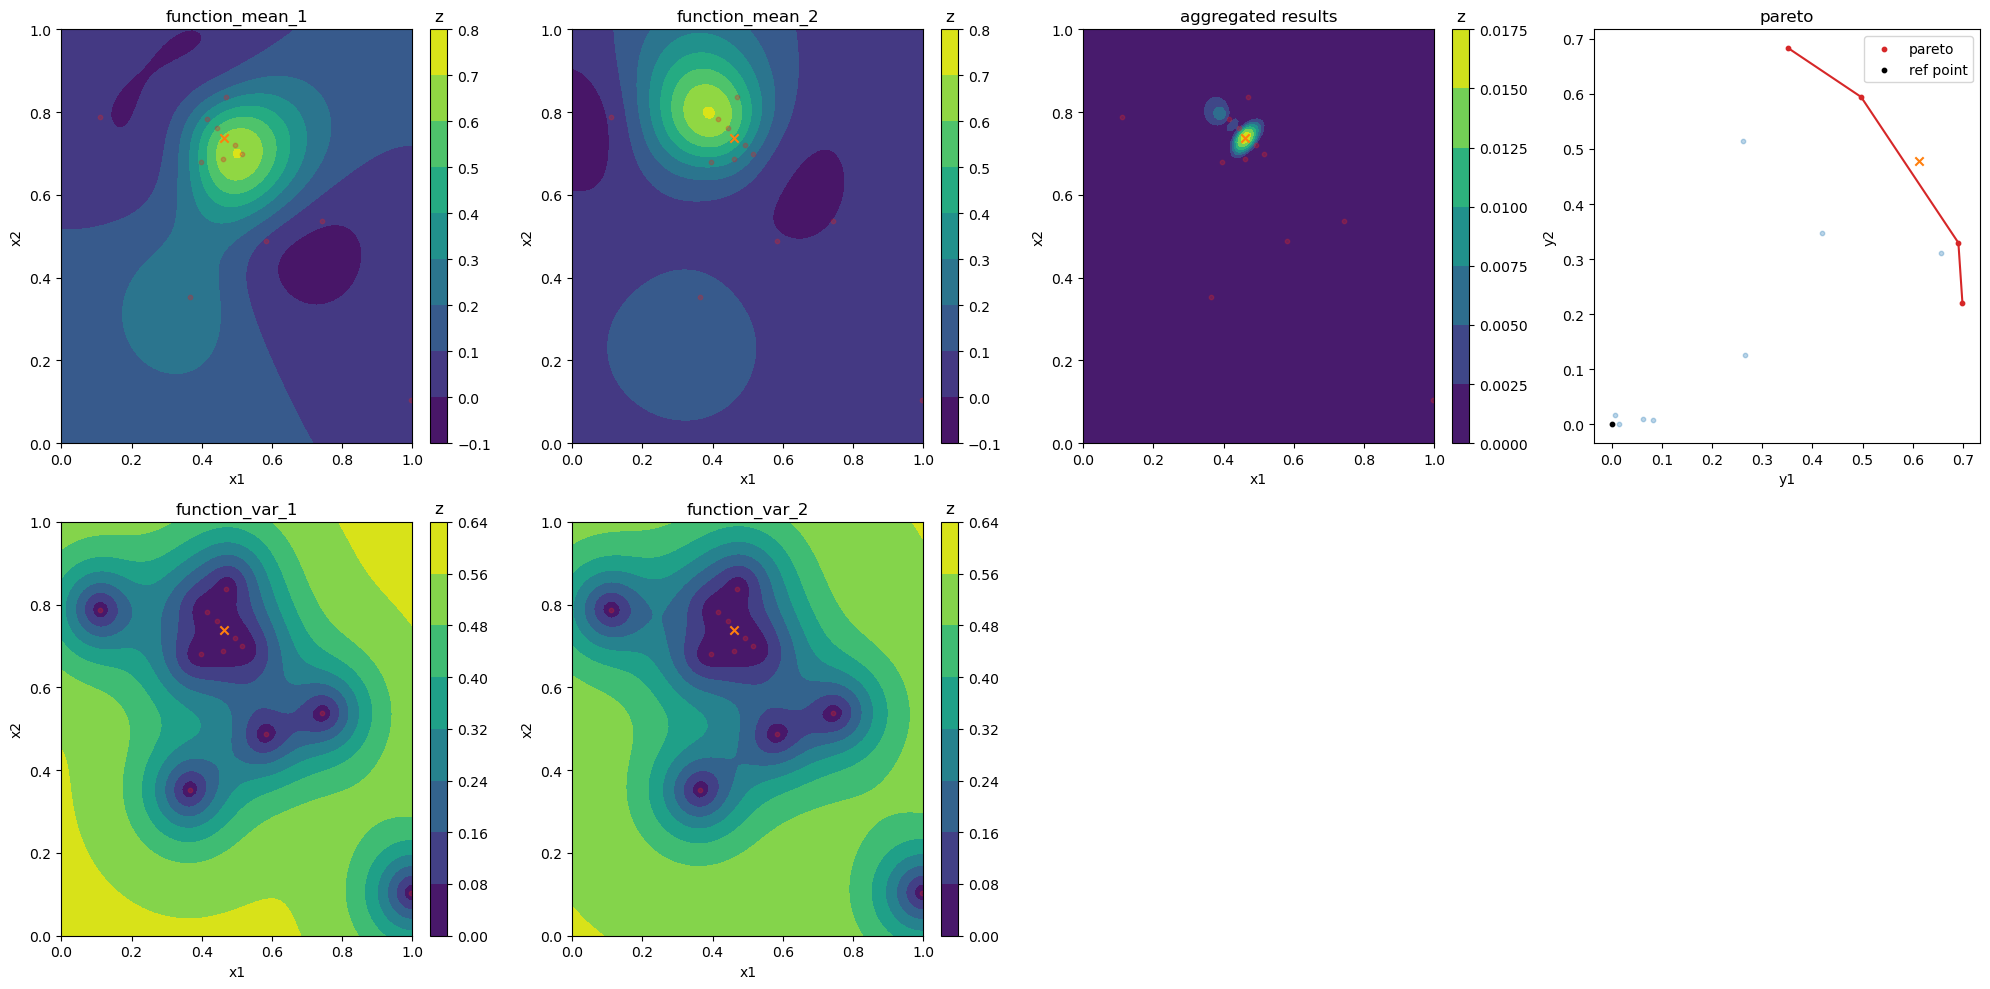

2024-05-07 10:01:49,379 | Model fitting takes 0.04s


Iteration 7


2024-05-07 10:01:50,107 | Optimizing the acquisition function takes 0.72s


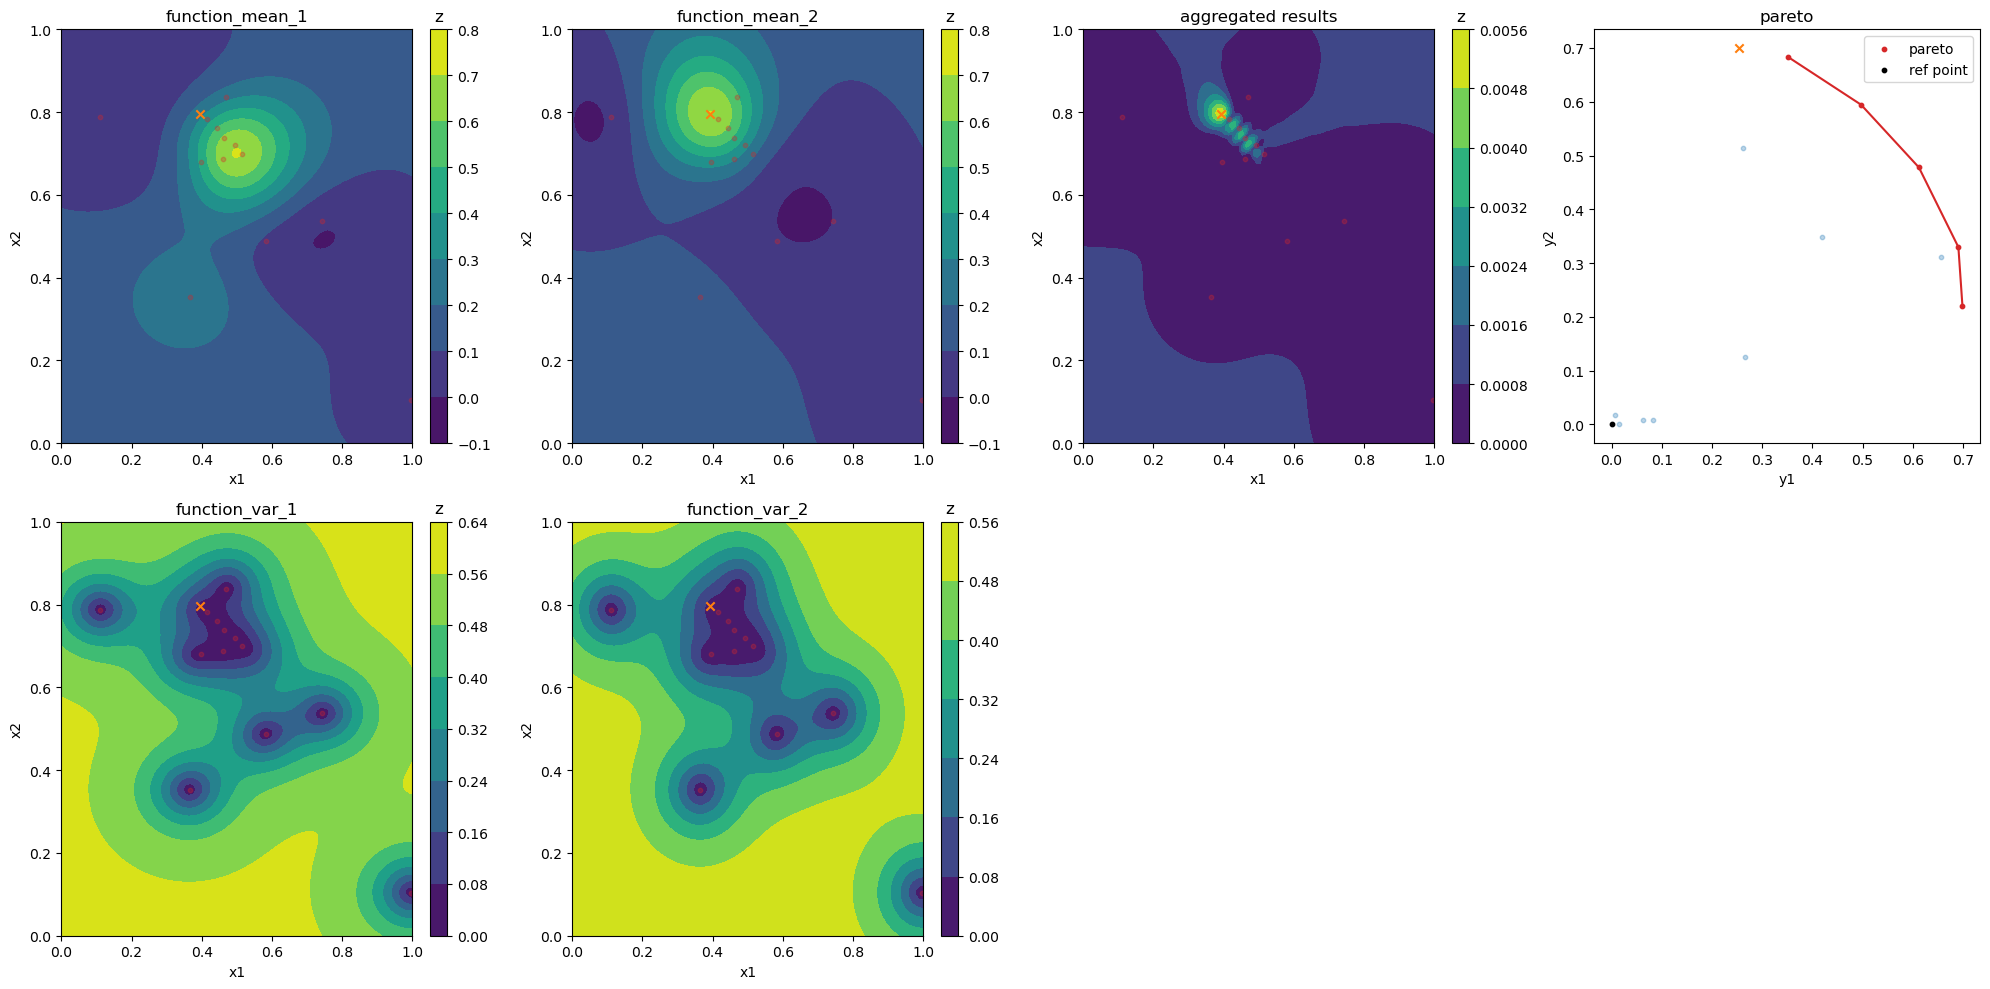

Iteration 8


2024-05-07 10:01:51,680 | Model fitting takes 0.27s
2024-05-07 10:01:52,359 | Optimizing the acquisition function takes 0.67s


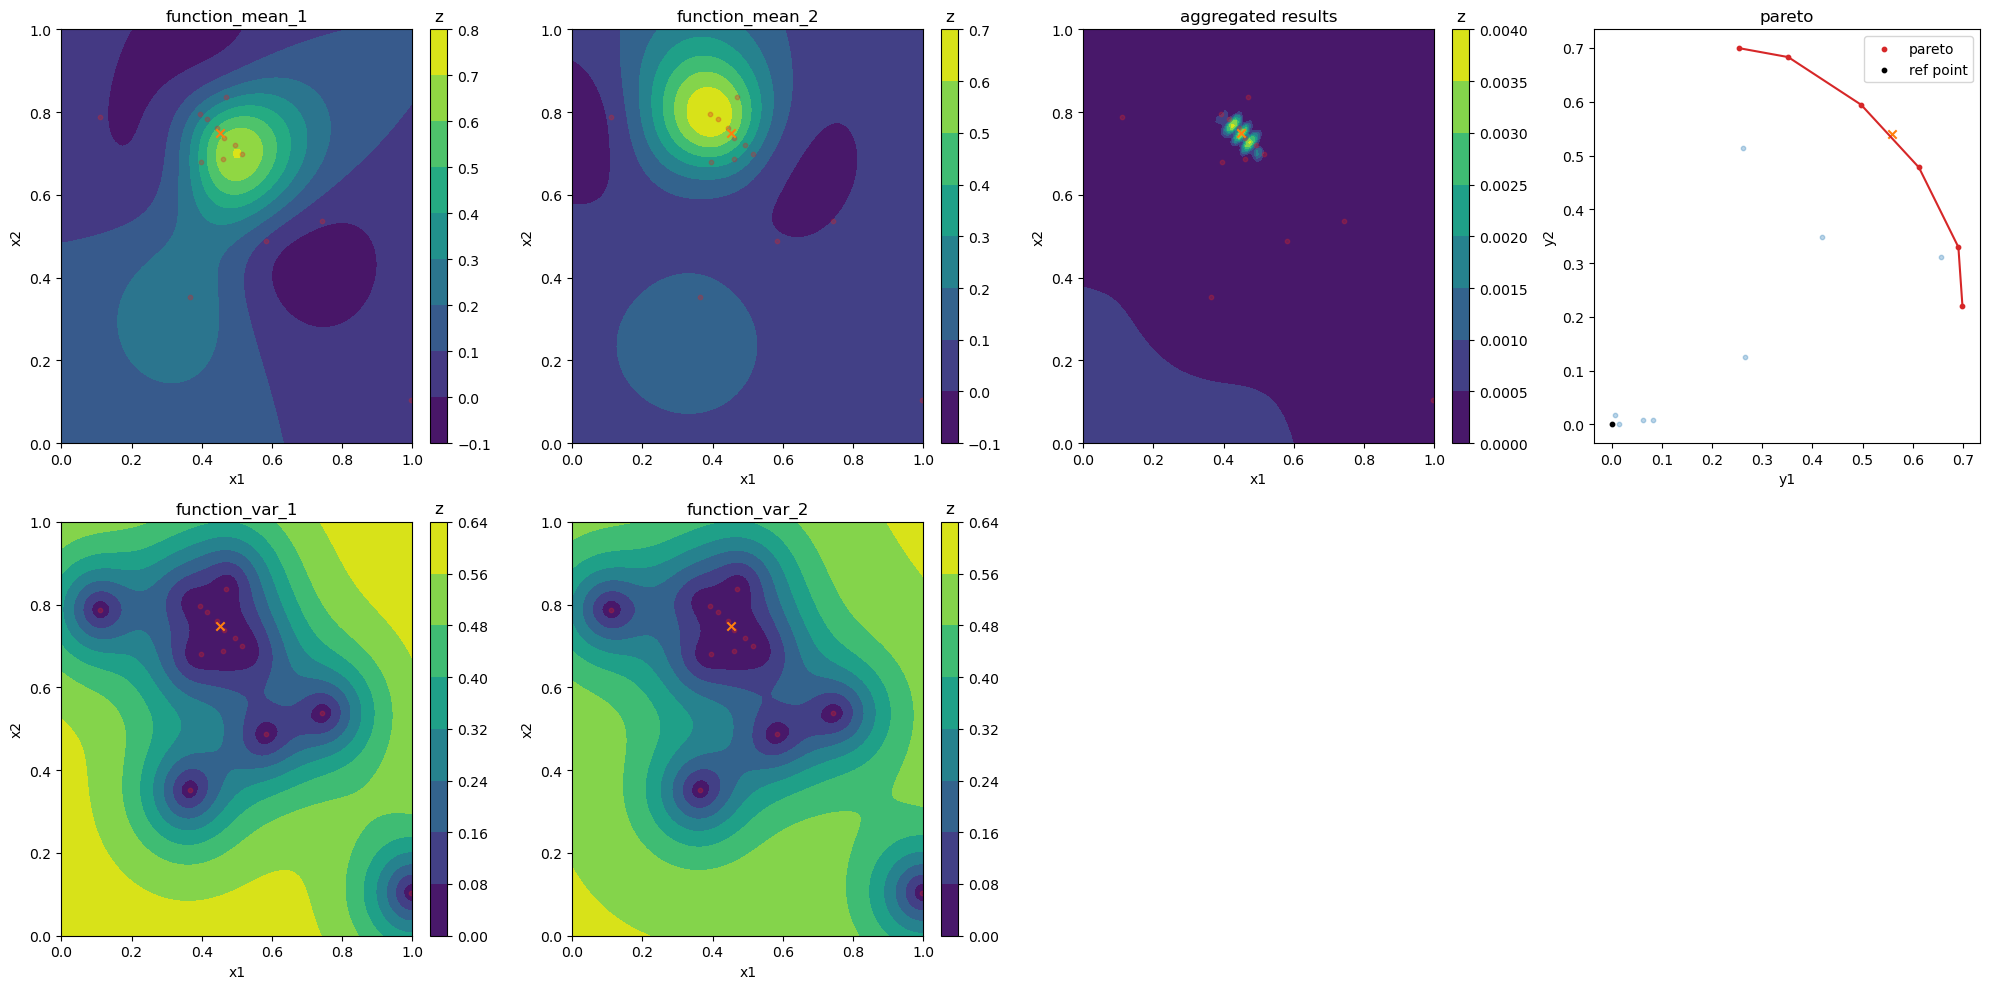

Iteration 9


2024-05-07 10:01:53,876 | Model fitting takes 0.35s
2024-05-07 10:01:54,555 | Optimizing the acquisition function takes 0.67s


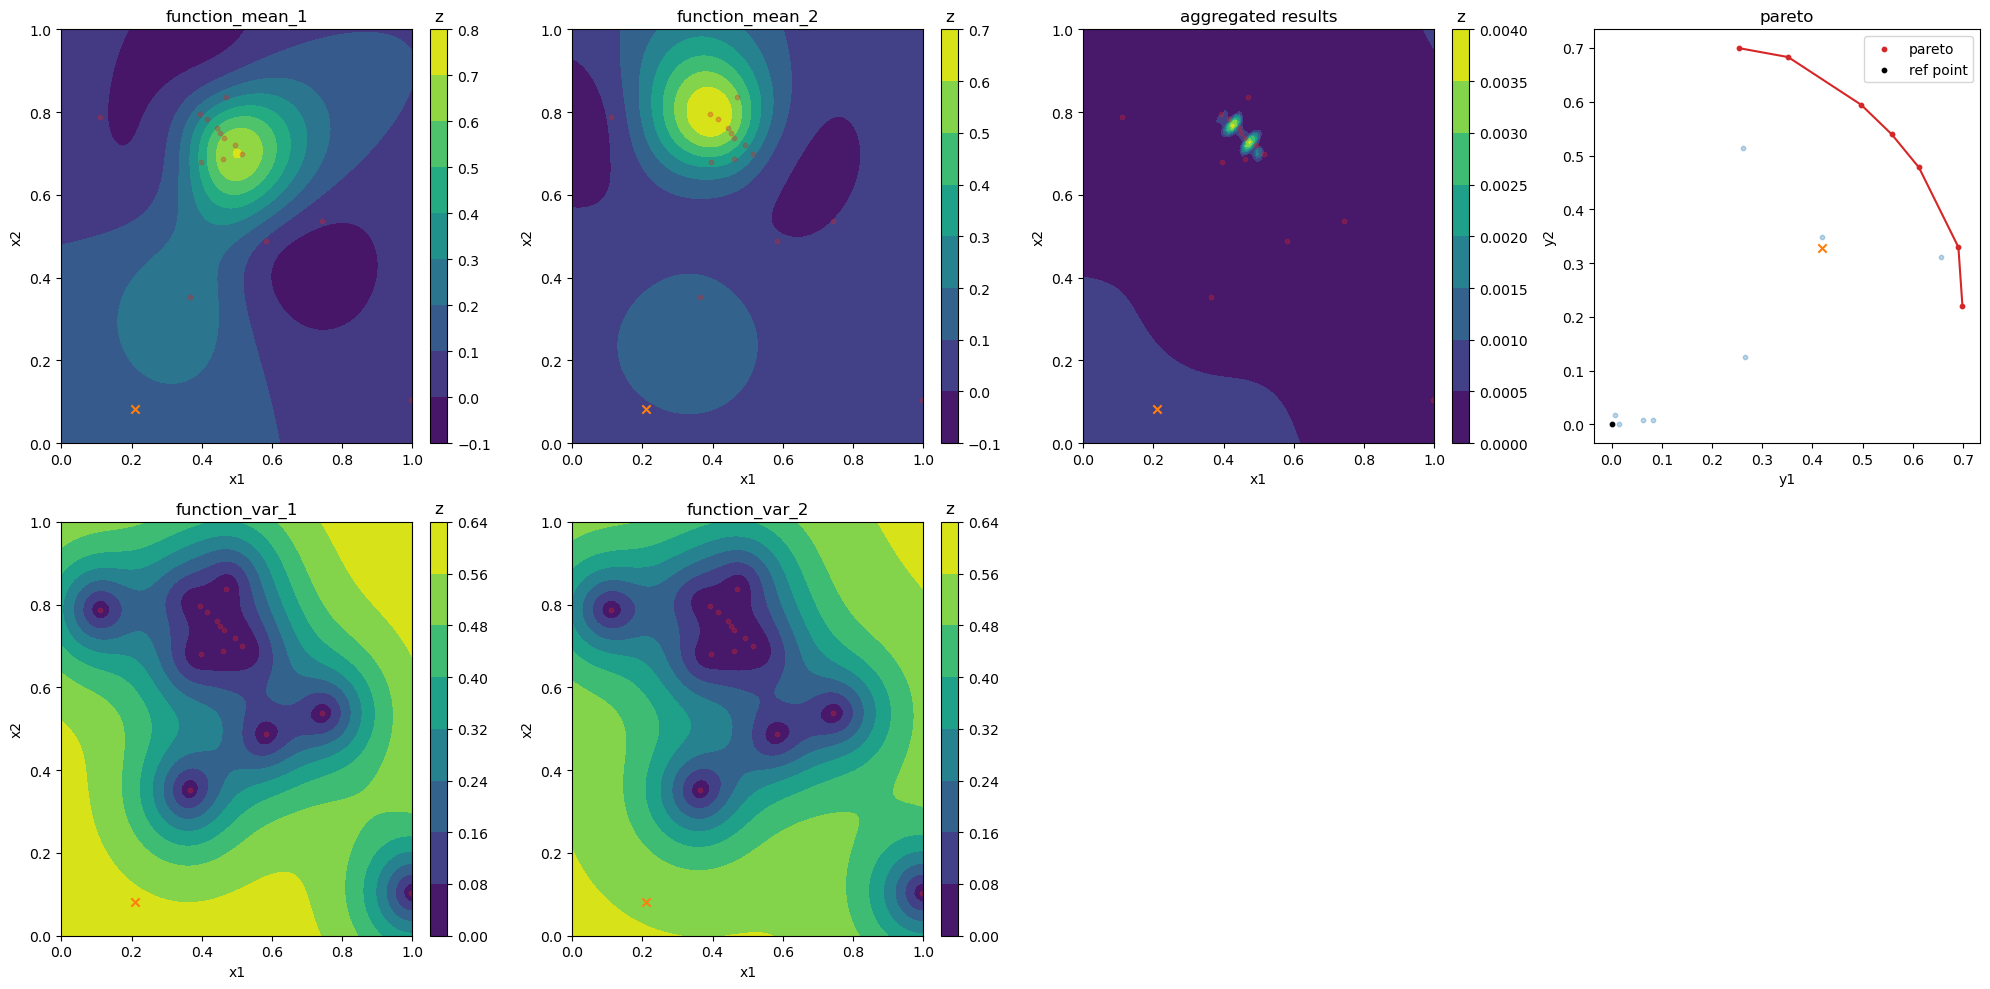

Iteration 10


2024-05-07 10:01:56,286 | Model fitting takes 0.39s
2024-05-07 10:01:56,898 | Optimizing the acquisition function takes 0.61s


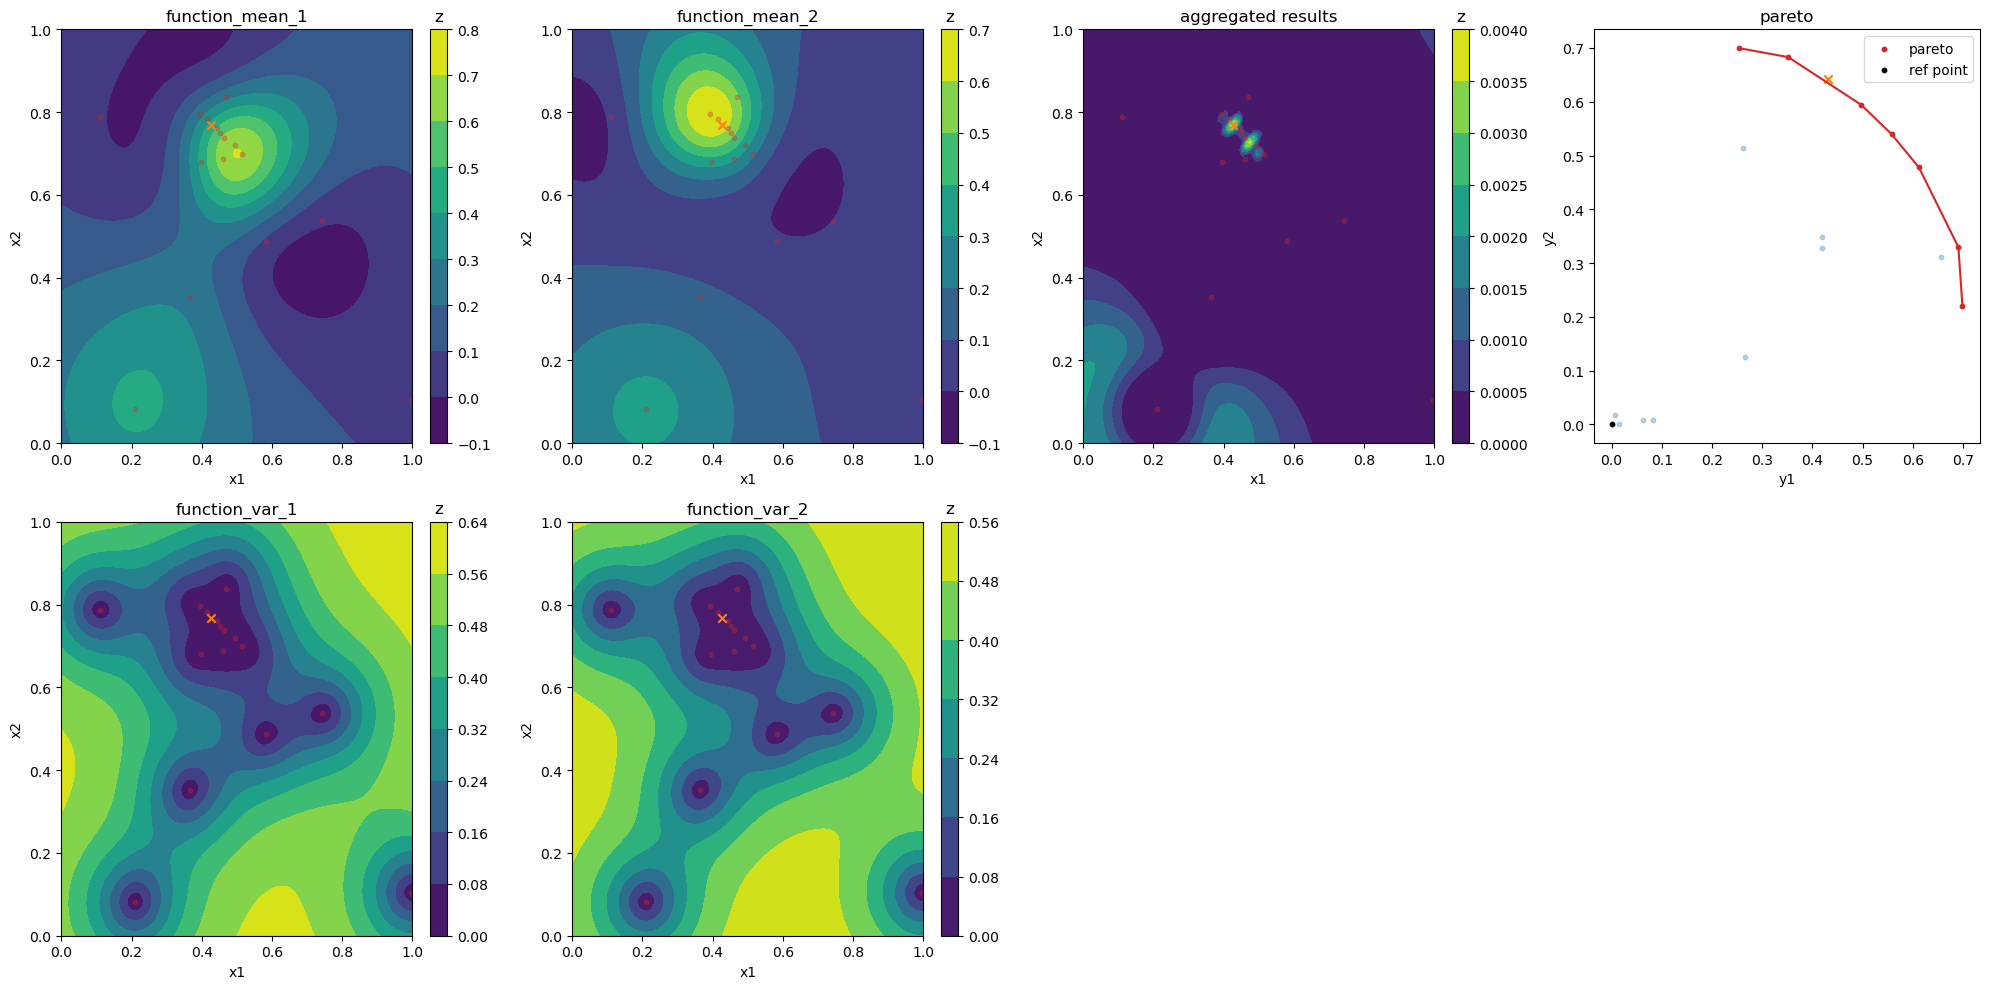

Iteration 11


2024-05-07 10:01:58,530 | Model fitting takes 0.43s
2024-05-07 10:01:59,312 | Optimizing the acquisition function takes 0.78s


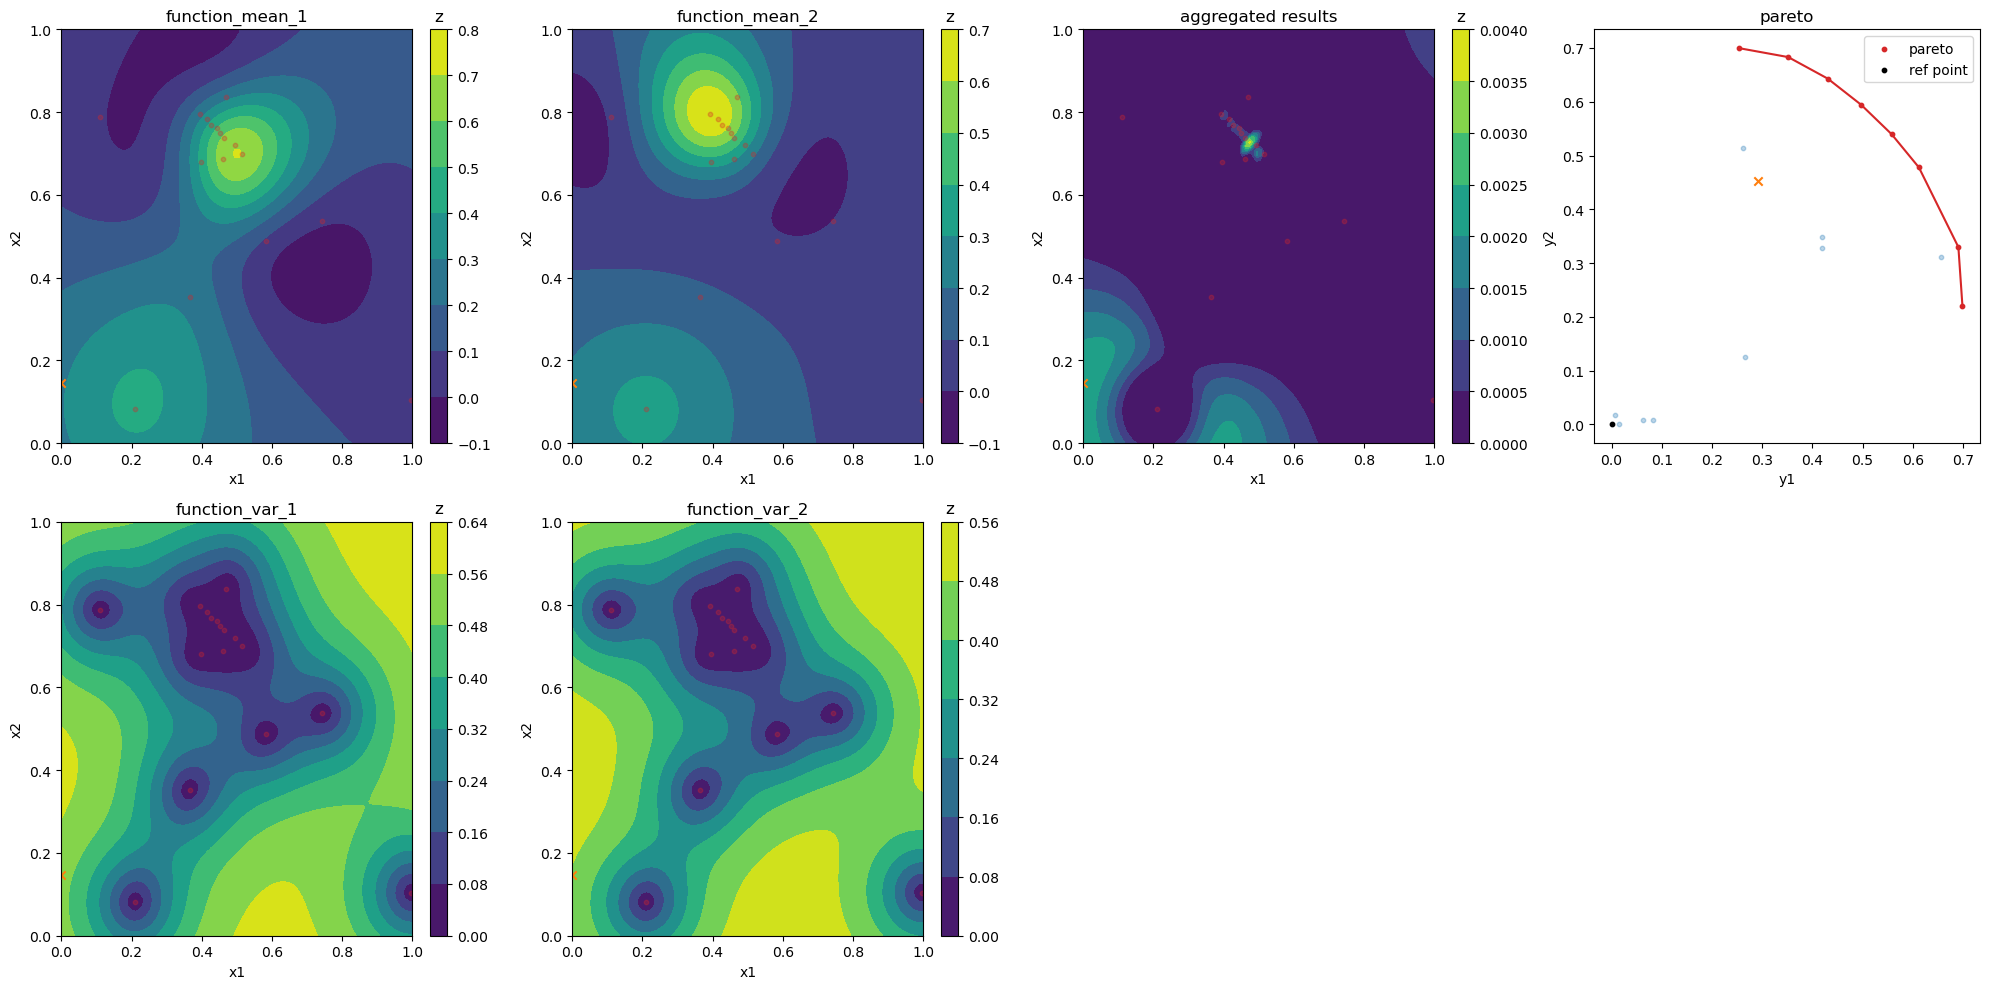

Iteration 12


2024-05-07 10:02:00,946 | Model fitting takes 0.46s
2024-05-07 10:02:01,555 | Optimizing the acquisition function takes 0.60s


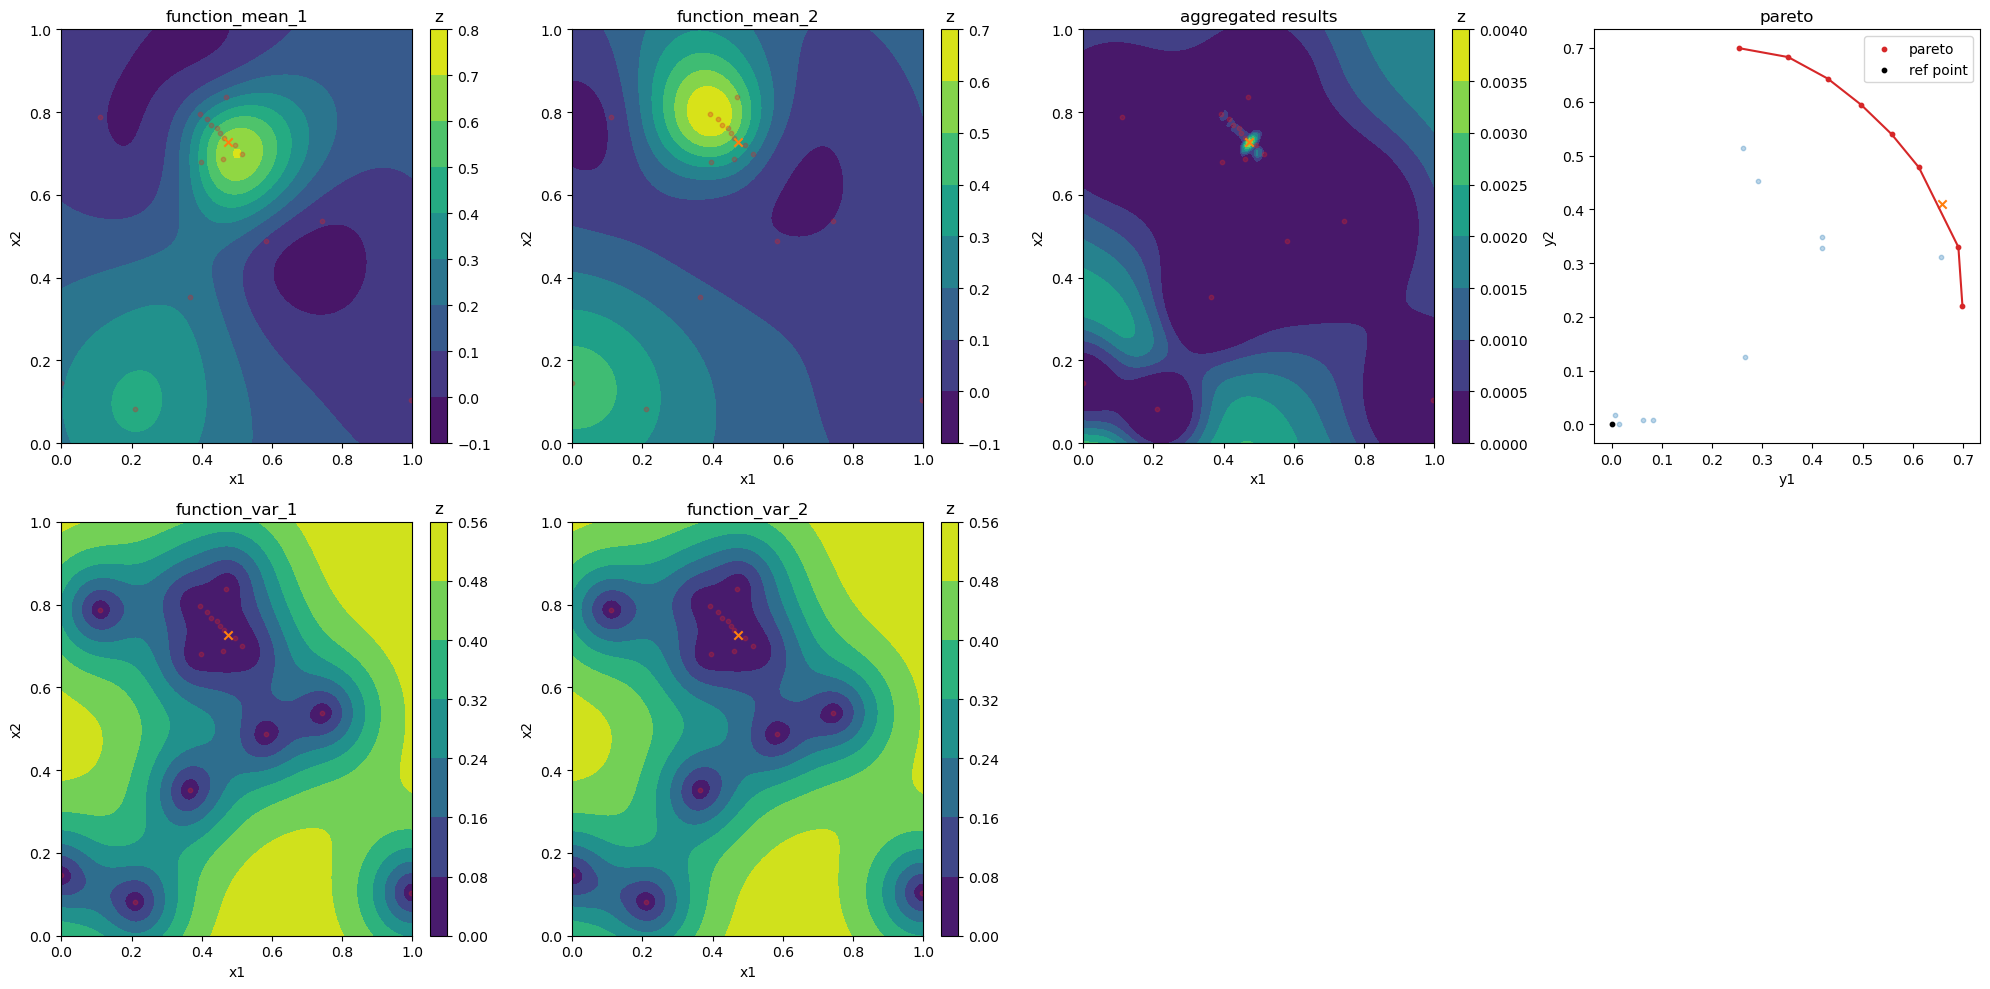

Iteration 13


2024-05-07 10:02:03,284 | Model fitting takes 0.40s
2024-05-07 10:02:03,823 | Optimizing the acquisition function takes 0.53s


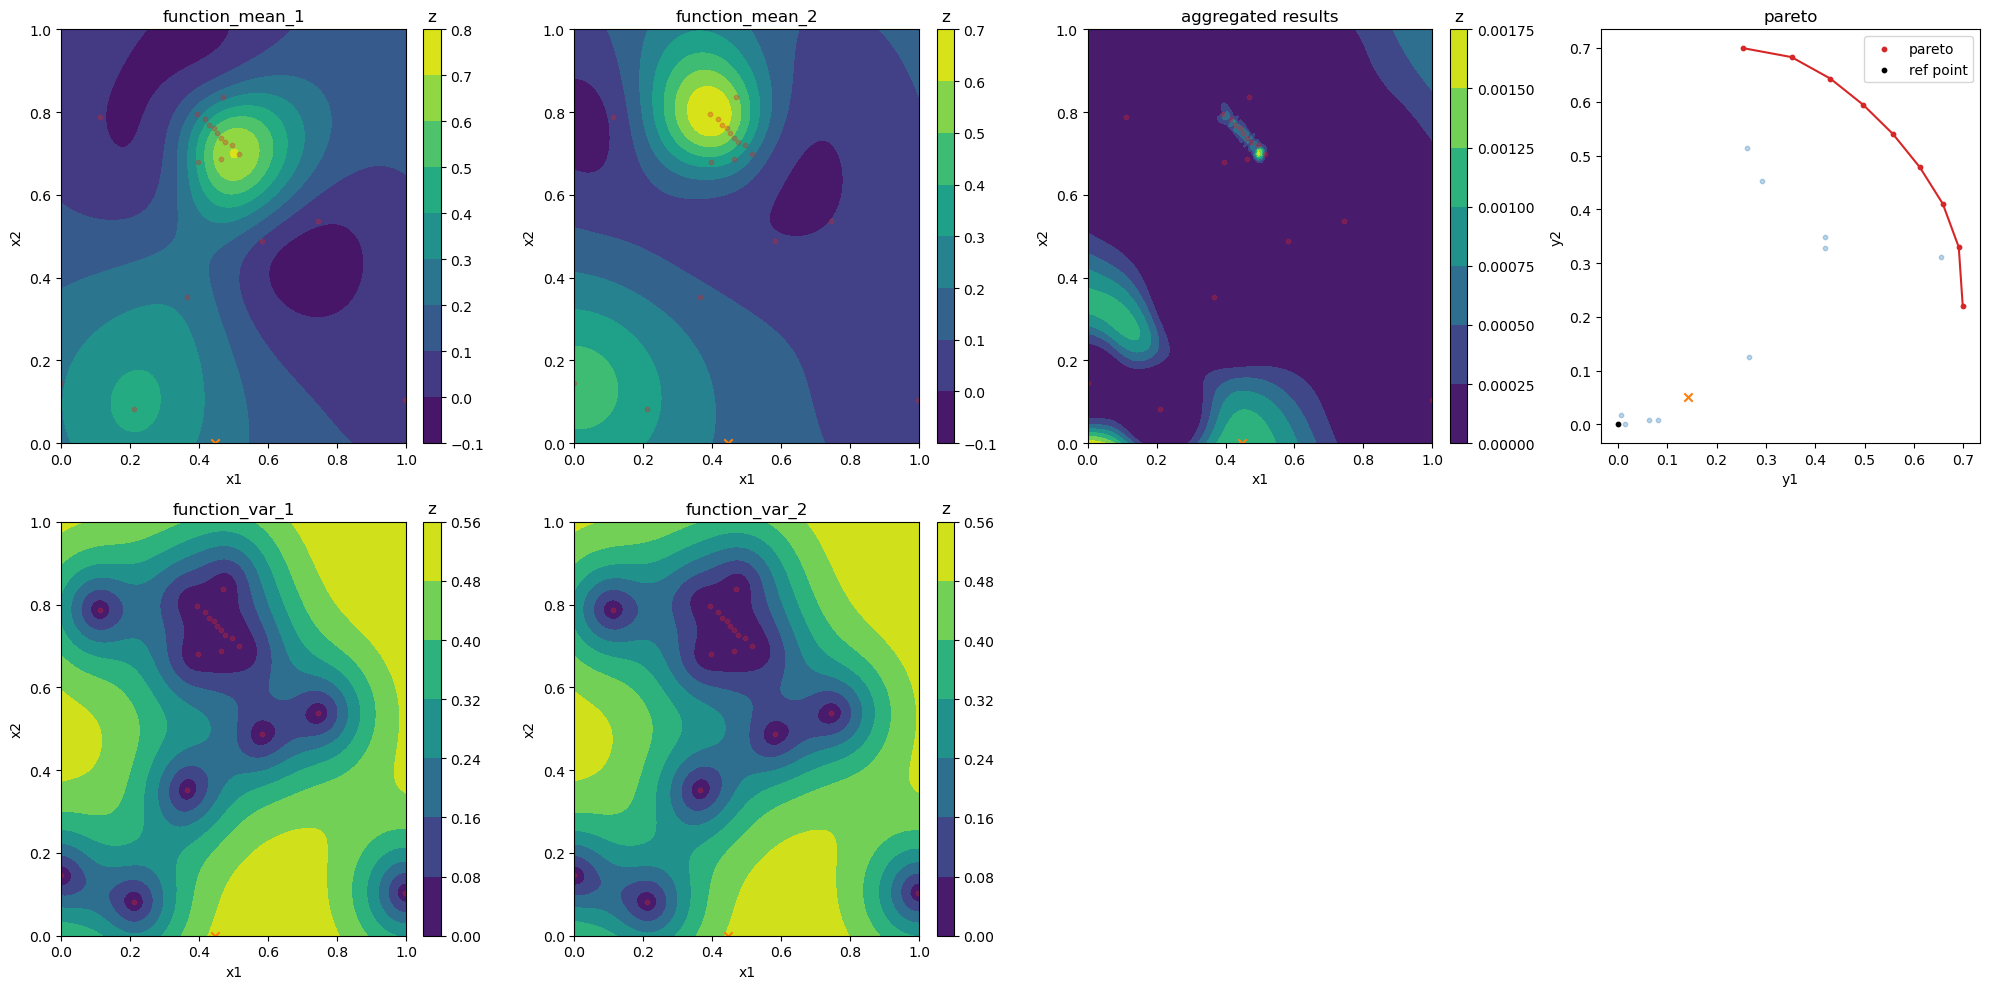

Iteration 14


2024-05-07 10:02:05,463 | Model fitting takes 0.42s
2024-05-07 10:02:06,303 | Optimizing the acquisition function takes 0.84s


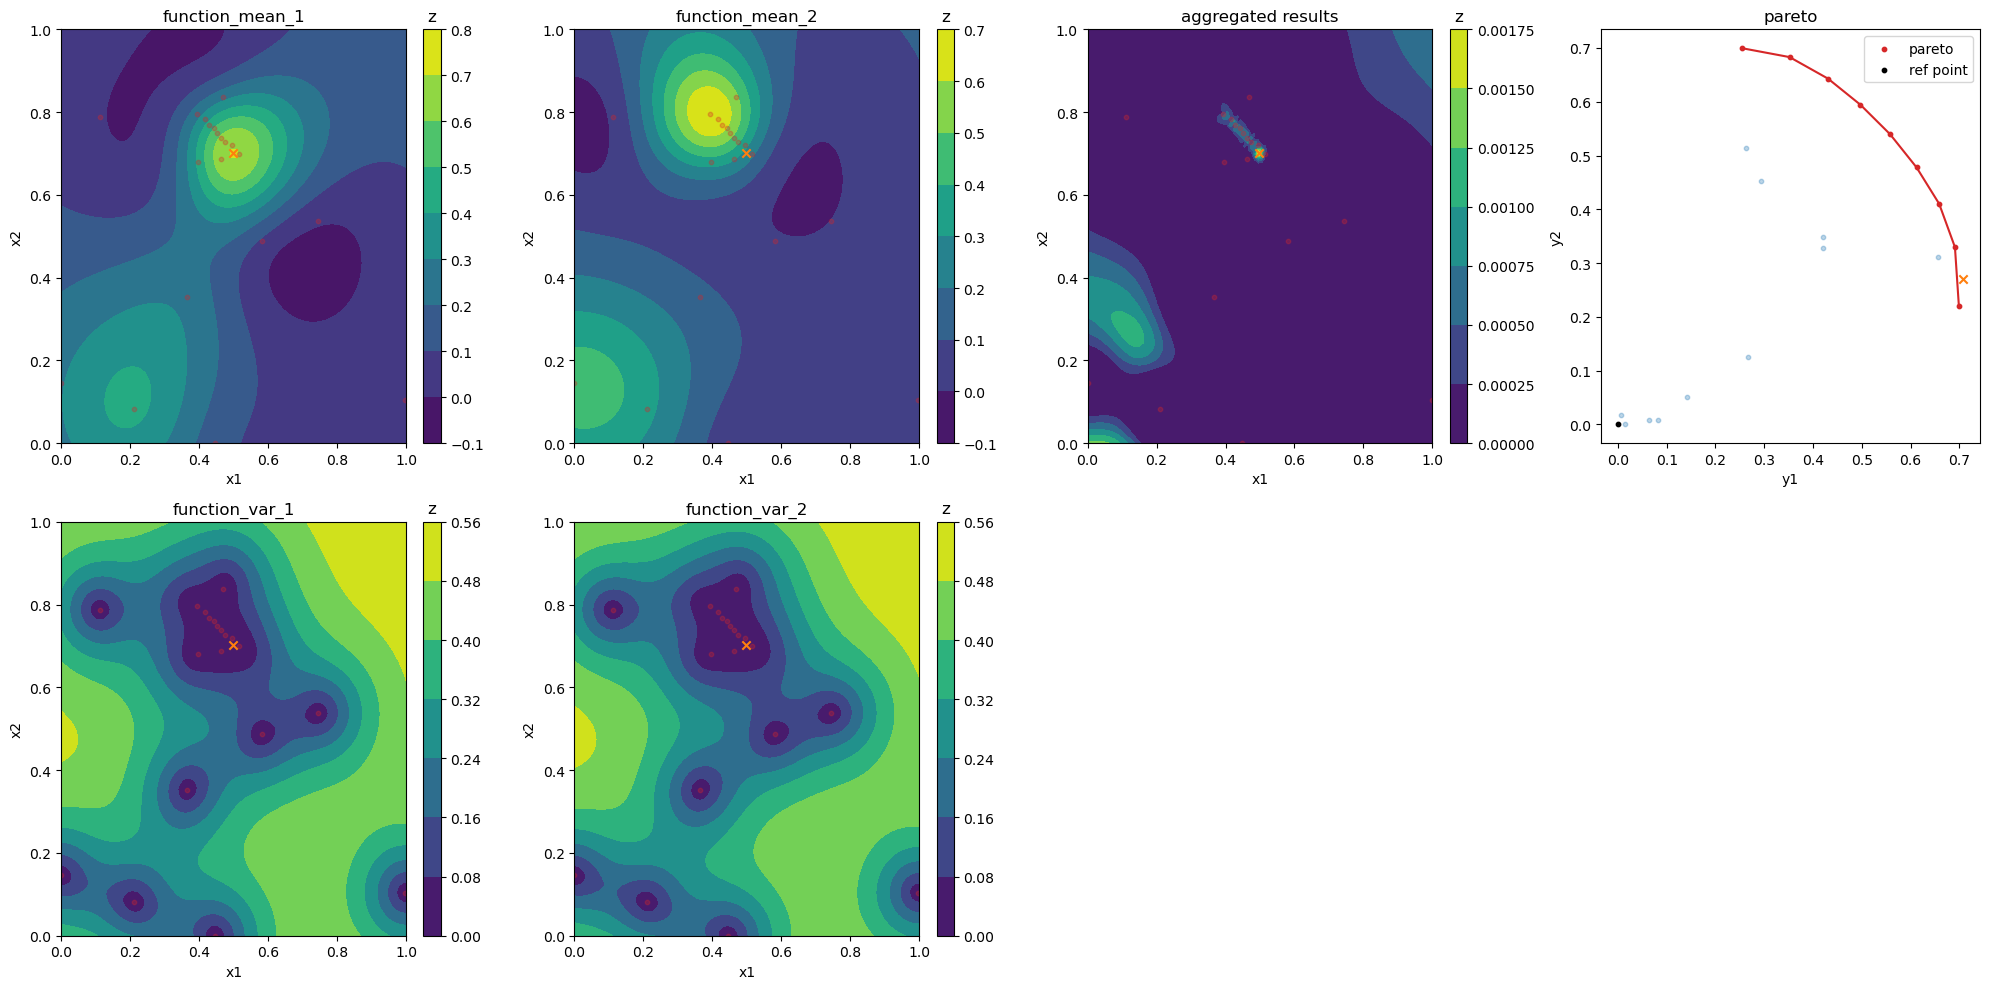

Iteration 15


2024-05-07 10:02:07,881 | Model fitting takes 0.41s
2024-05-07 10:02:08,528 | Optimizing the acquisition function takes 0.64s


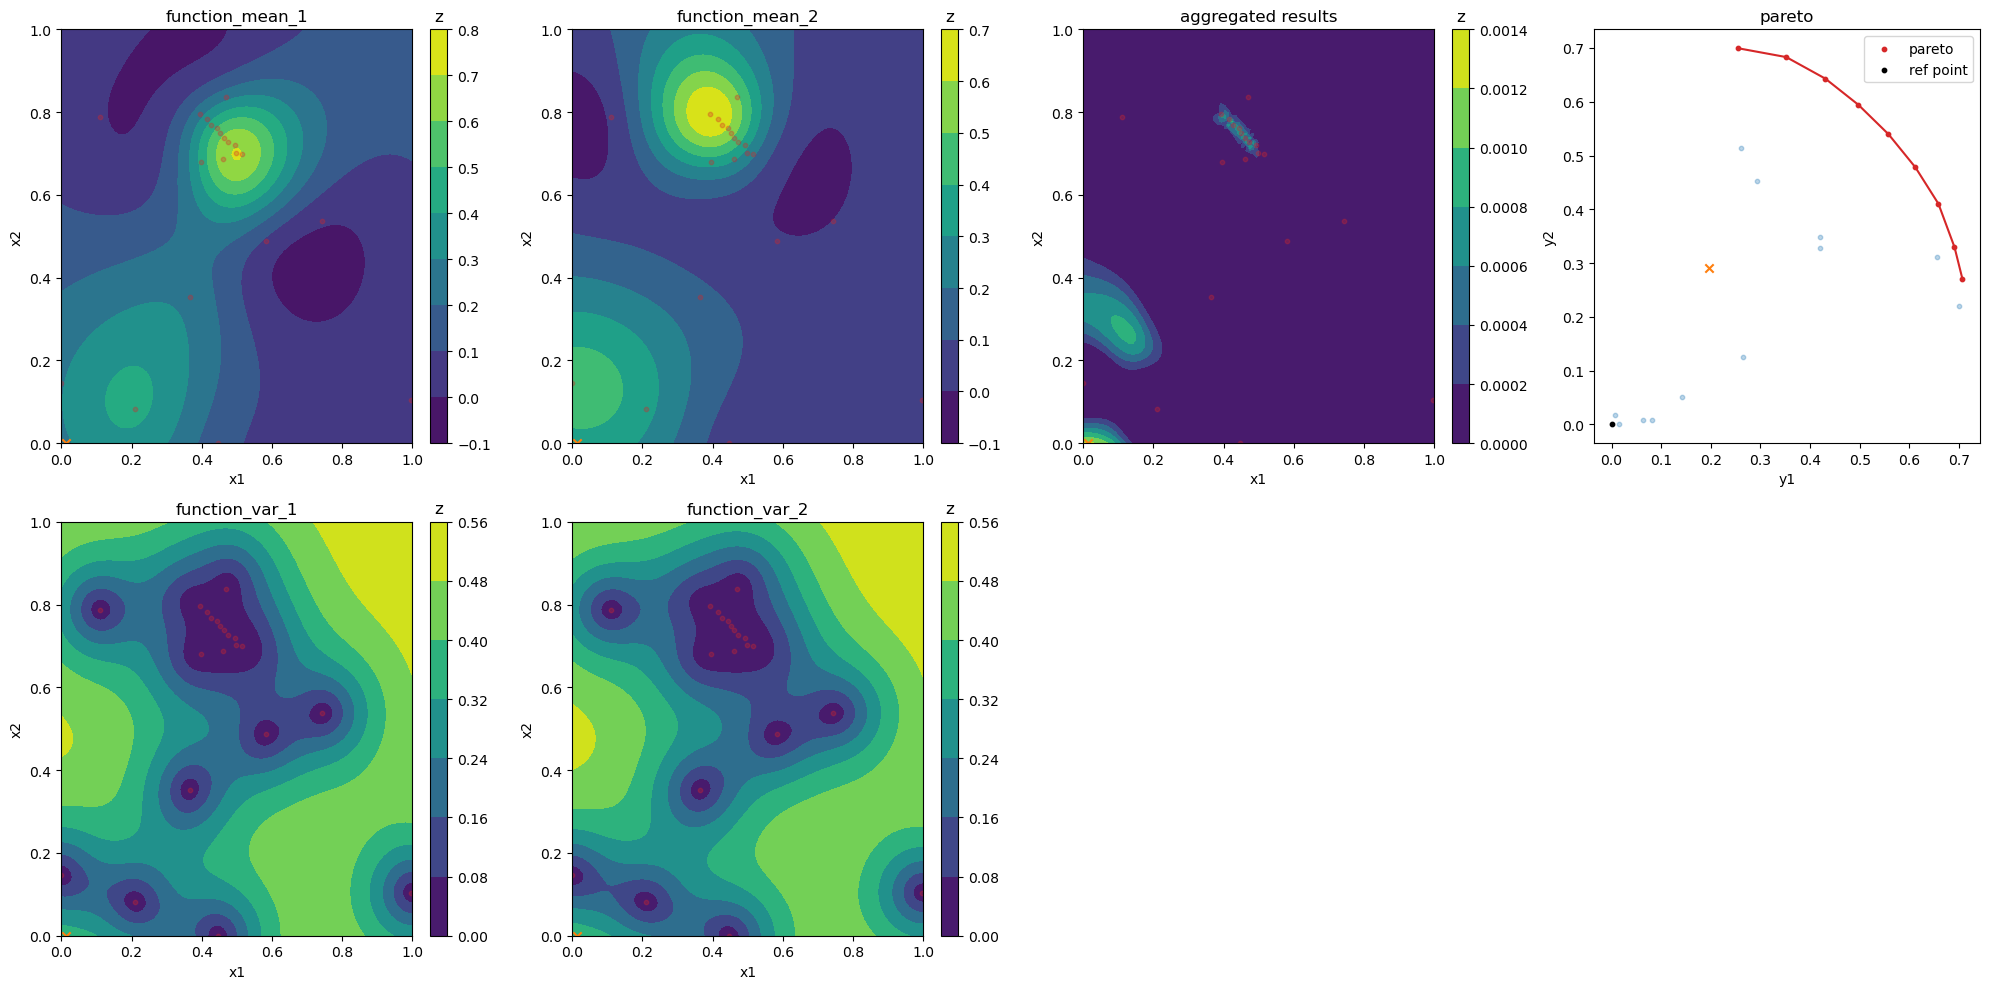

Iteration 16


2024-05-07 10:02:10,226 | Model fitting takes 0.30s
2024-05-07 10:02:10,800 | Optimizing the acquisition function takes 0.57s


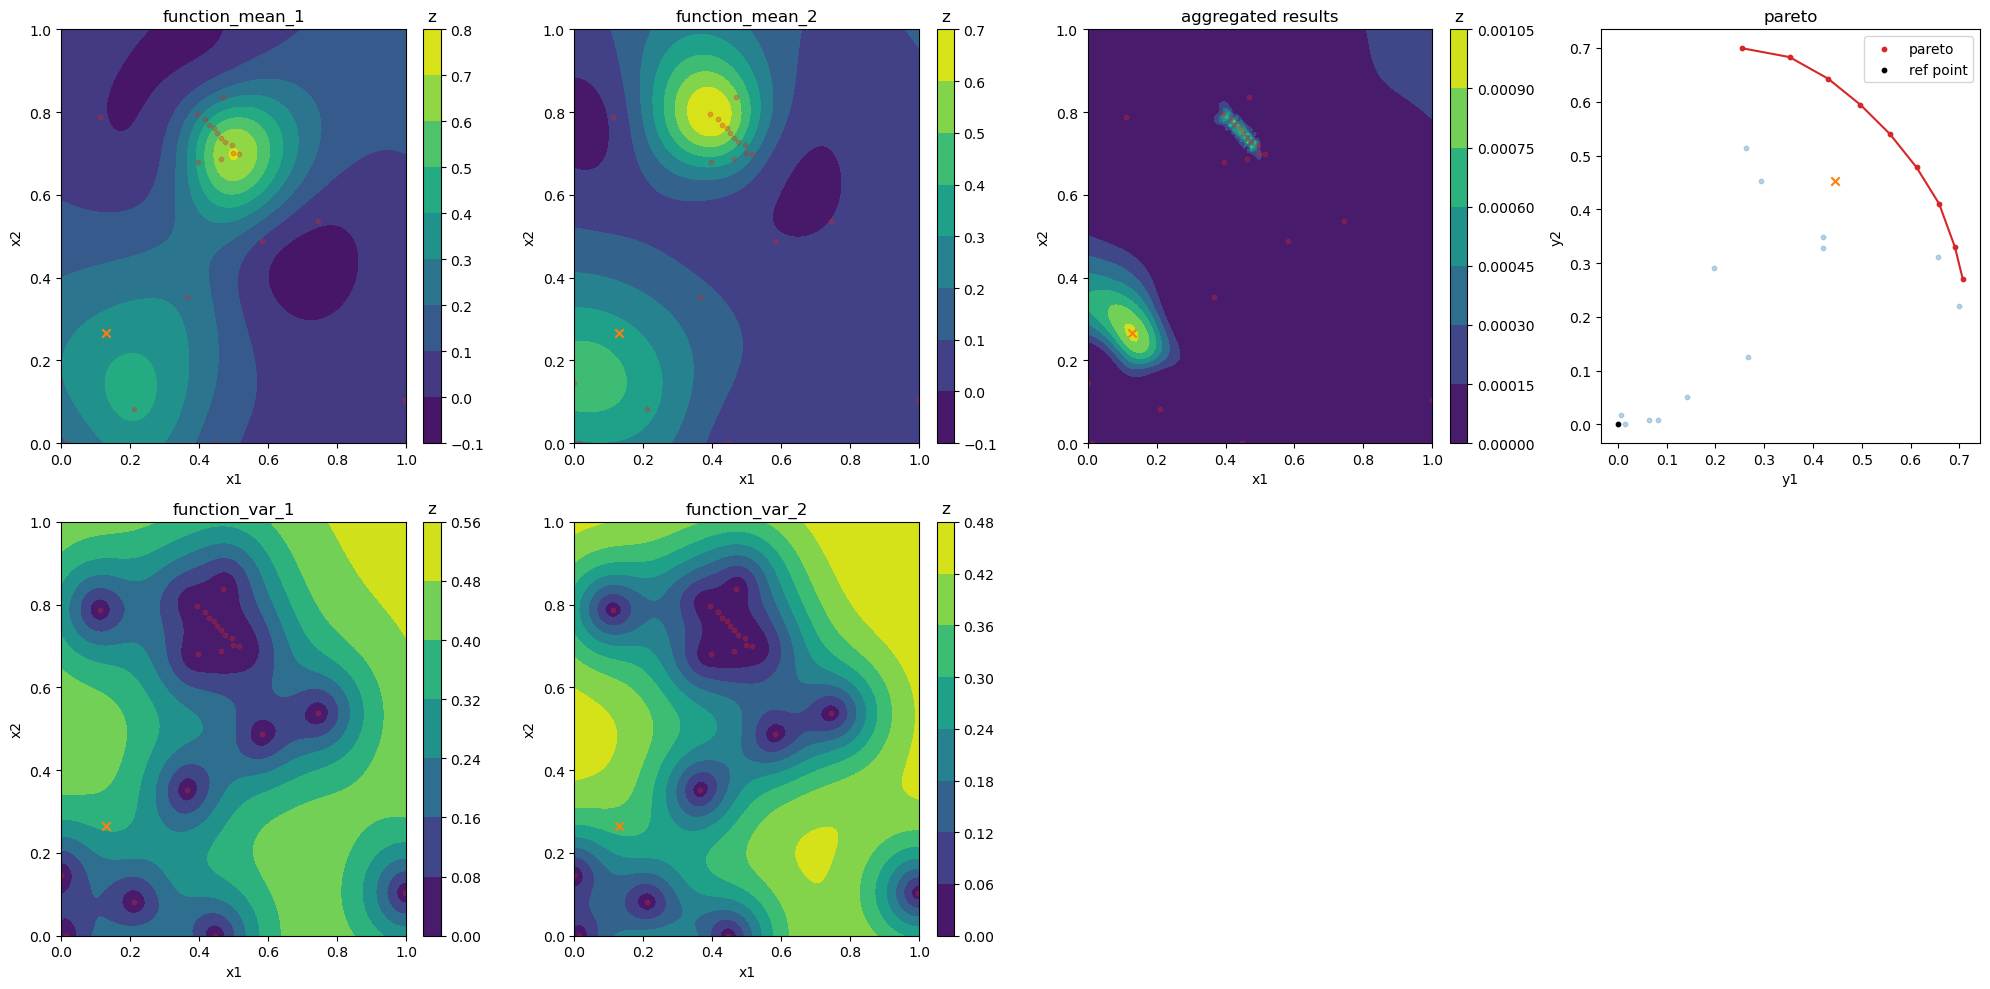

Iteration 17


2024-05-07 10:02:12,377 | Model fitting takes 0.40s
2024-05-07 10:02:12,918 | Optimizing the acquisition function takes 0.54s


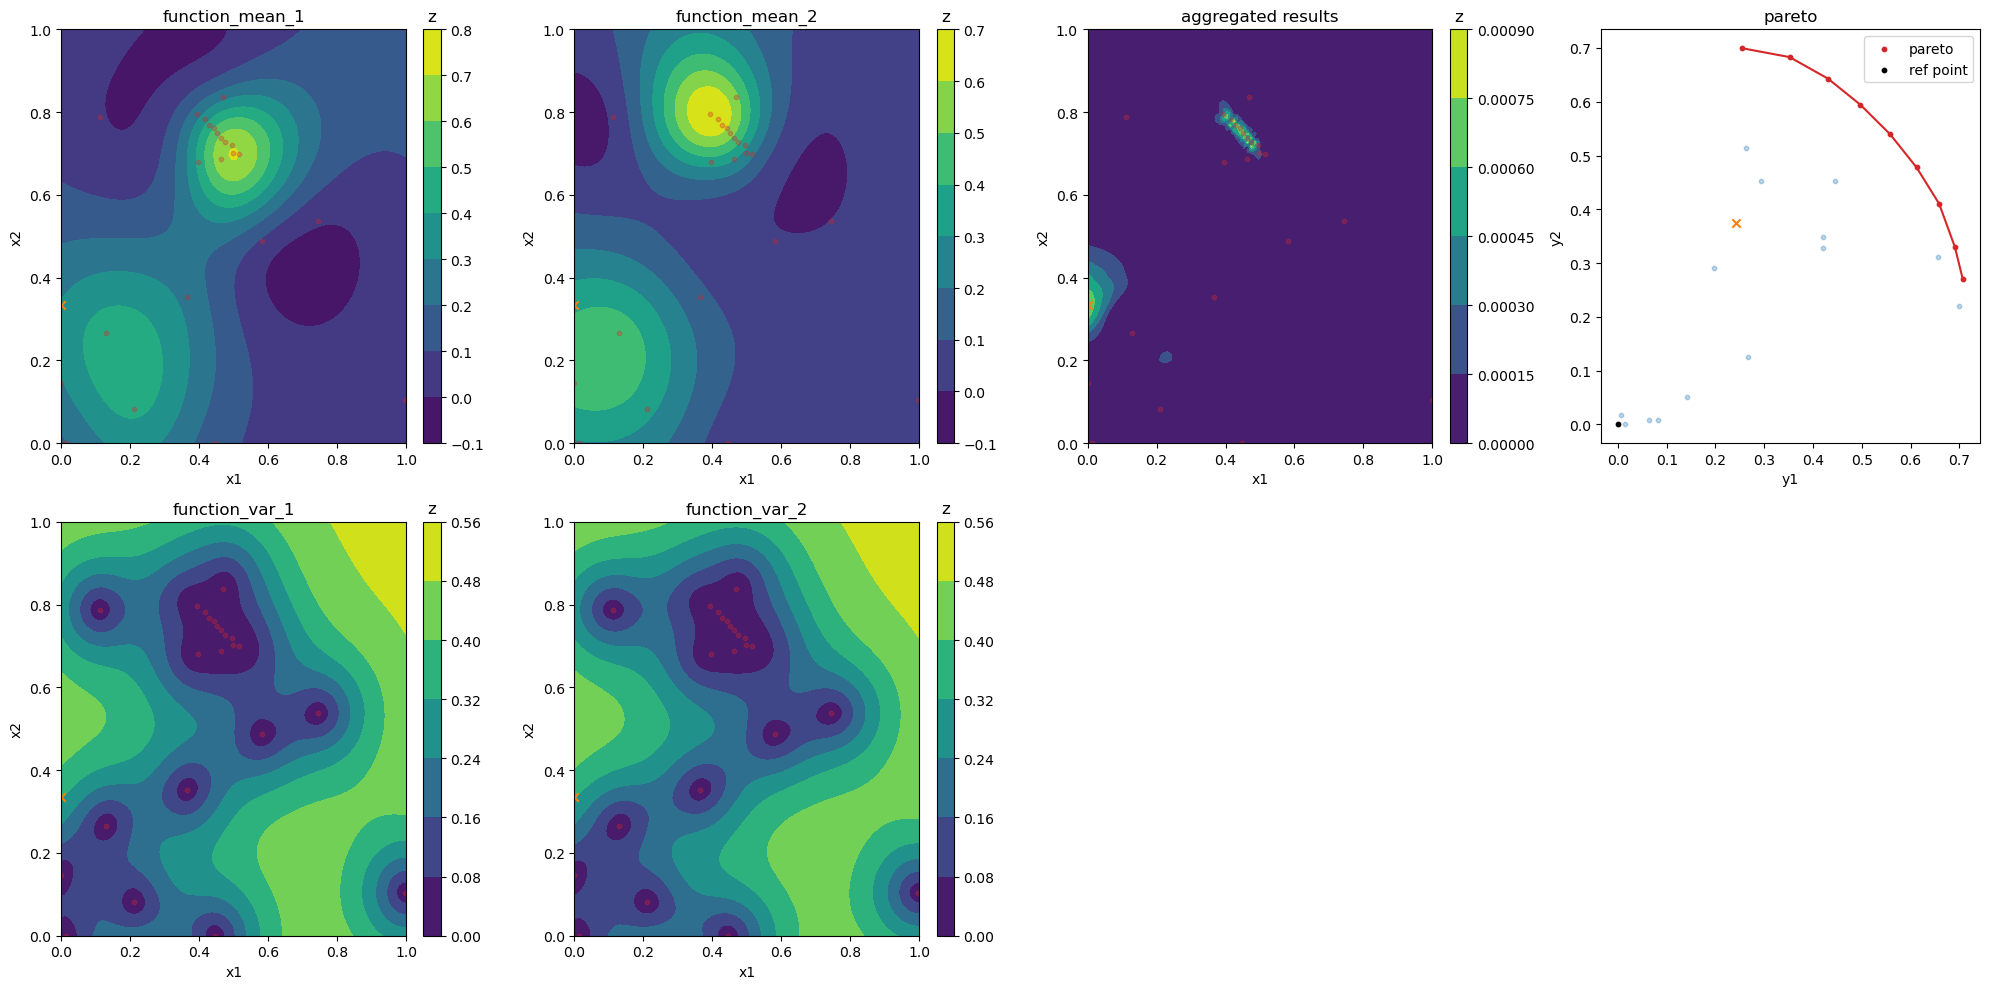

Iteration 18


2024-05-07 10:02:14,422 | Model fitting takes 0.33s
2024-05-07 10:02:15,356 | Optimizing the acquisition function takes 0.93s


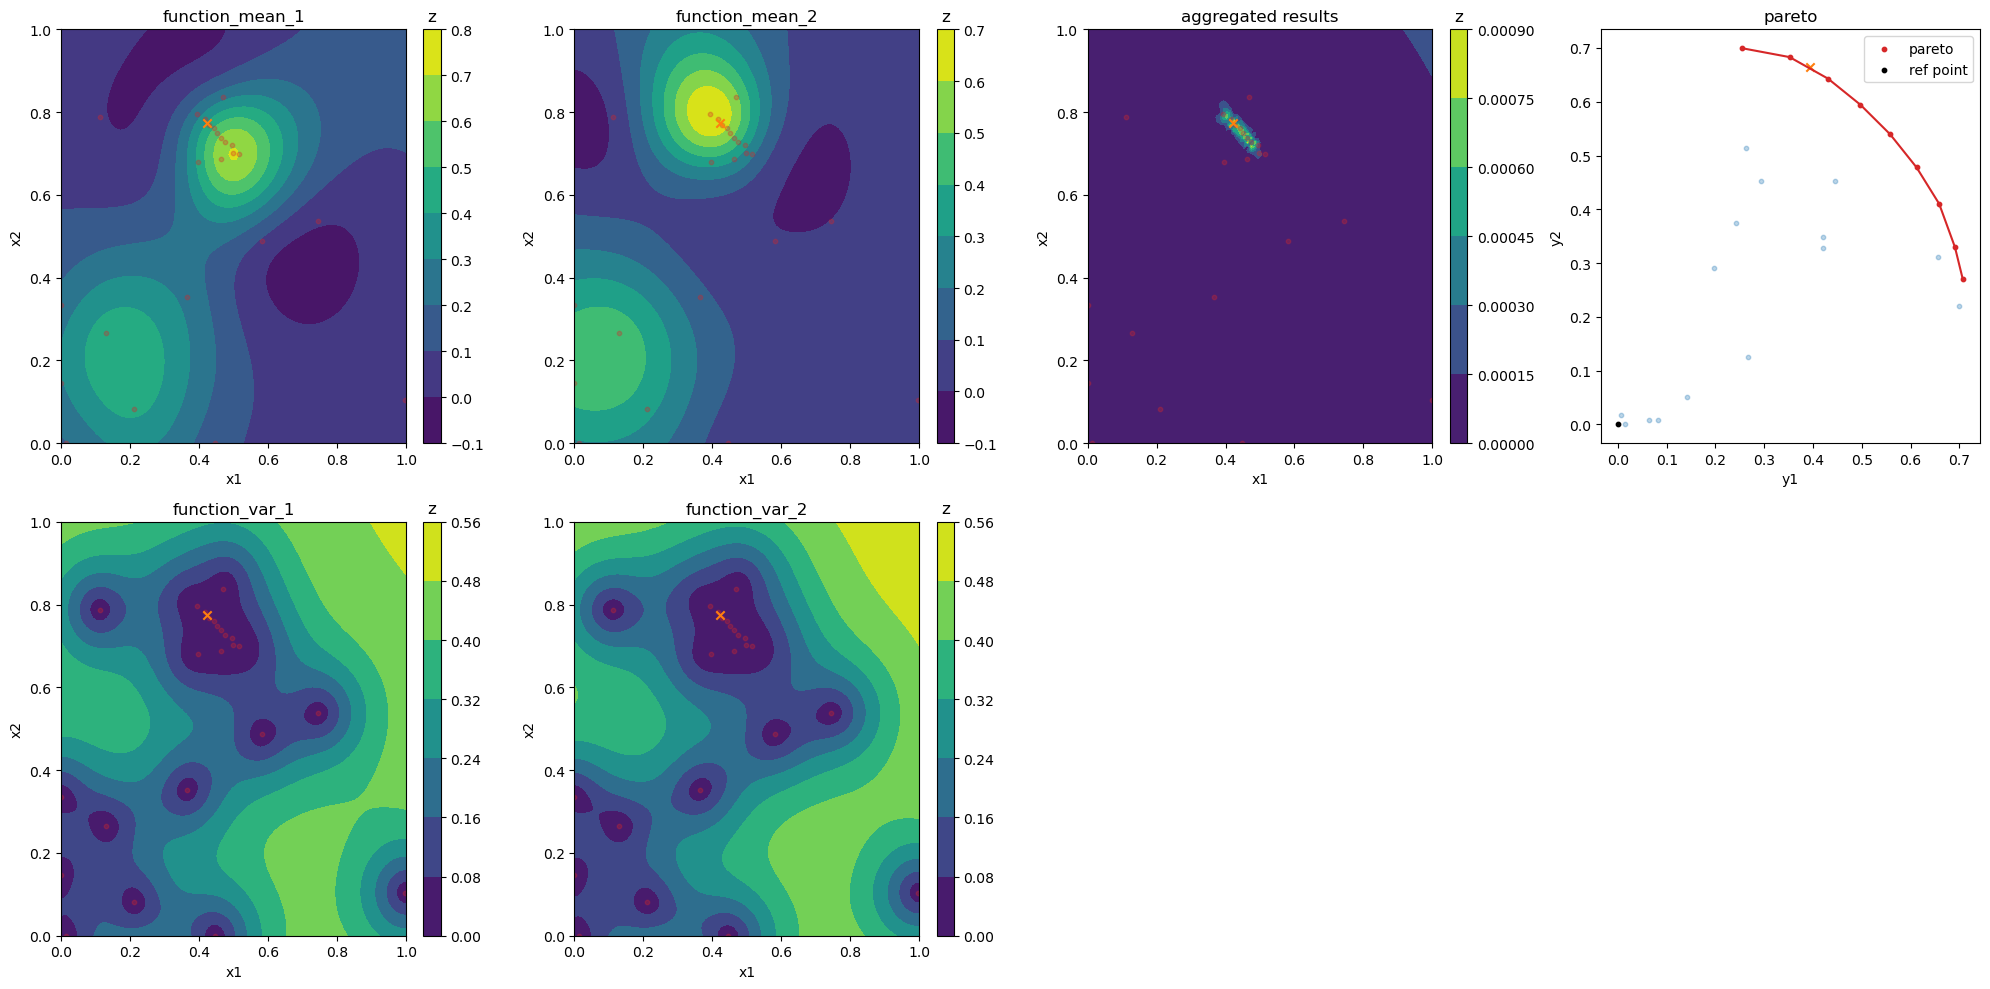

Iteration 19


2024-05-07 10:02:17,094 | Model fitting takes 0.40s
2024-05-07 10:02:17,919 | Optimizing the acquisition function takes 0.82s


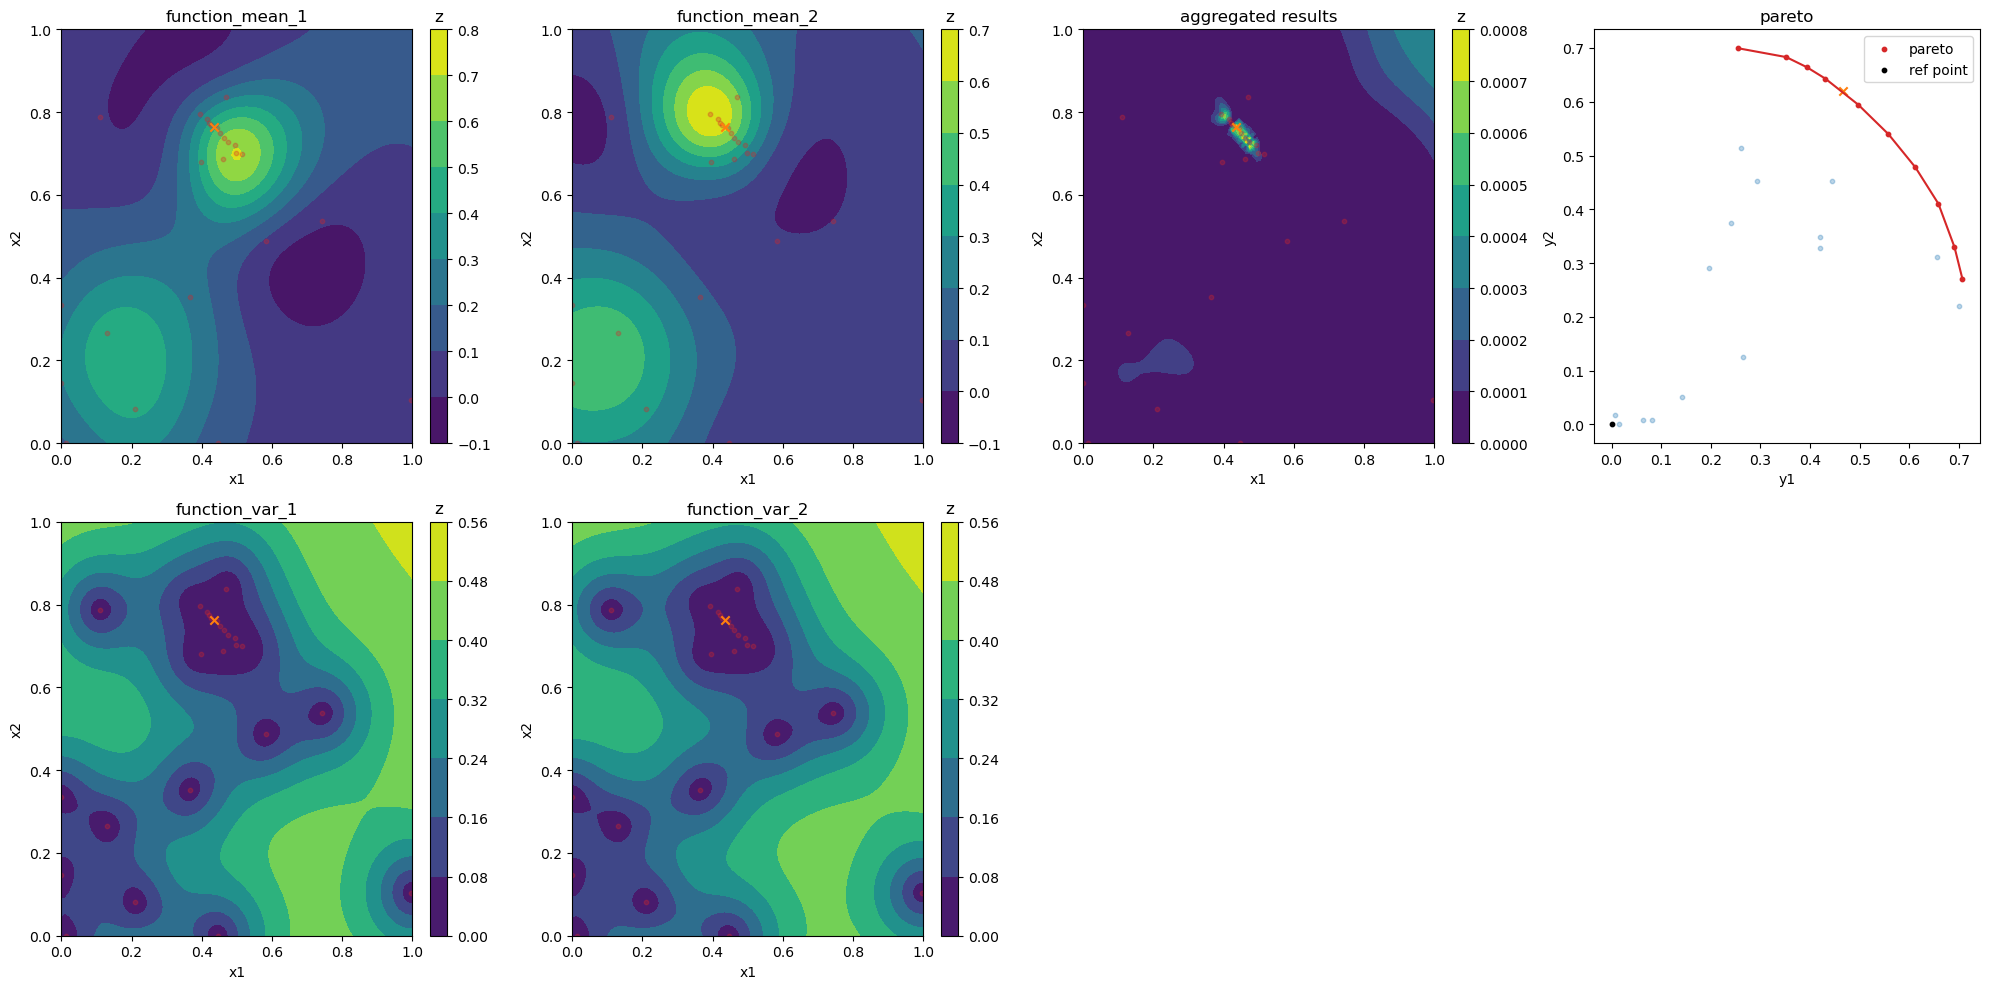

Iteration 20


2024-05-07 10:02:19,460 | Model fitting takes 0.35s
2024-05-07 10:02:20,944 | Optimizing the acquisition function takes 1.48s


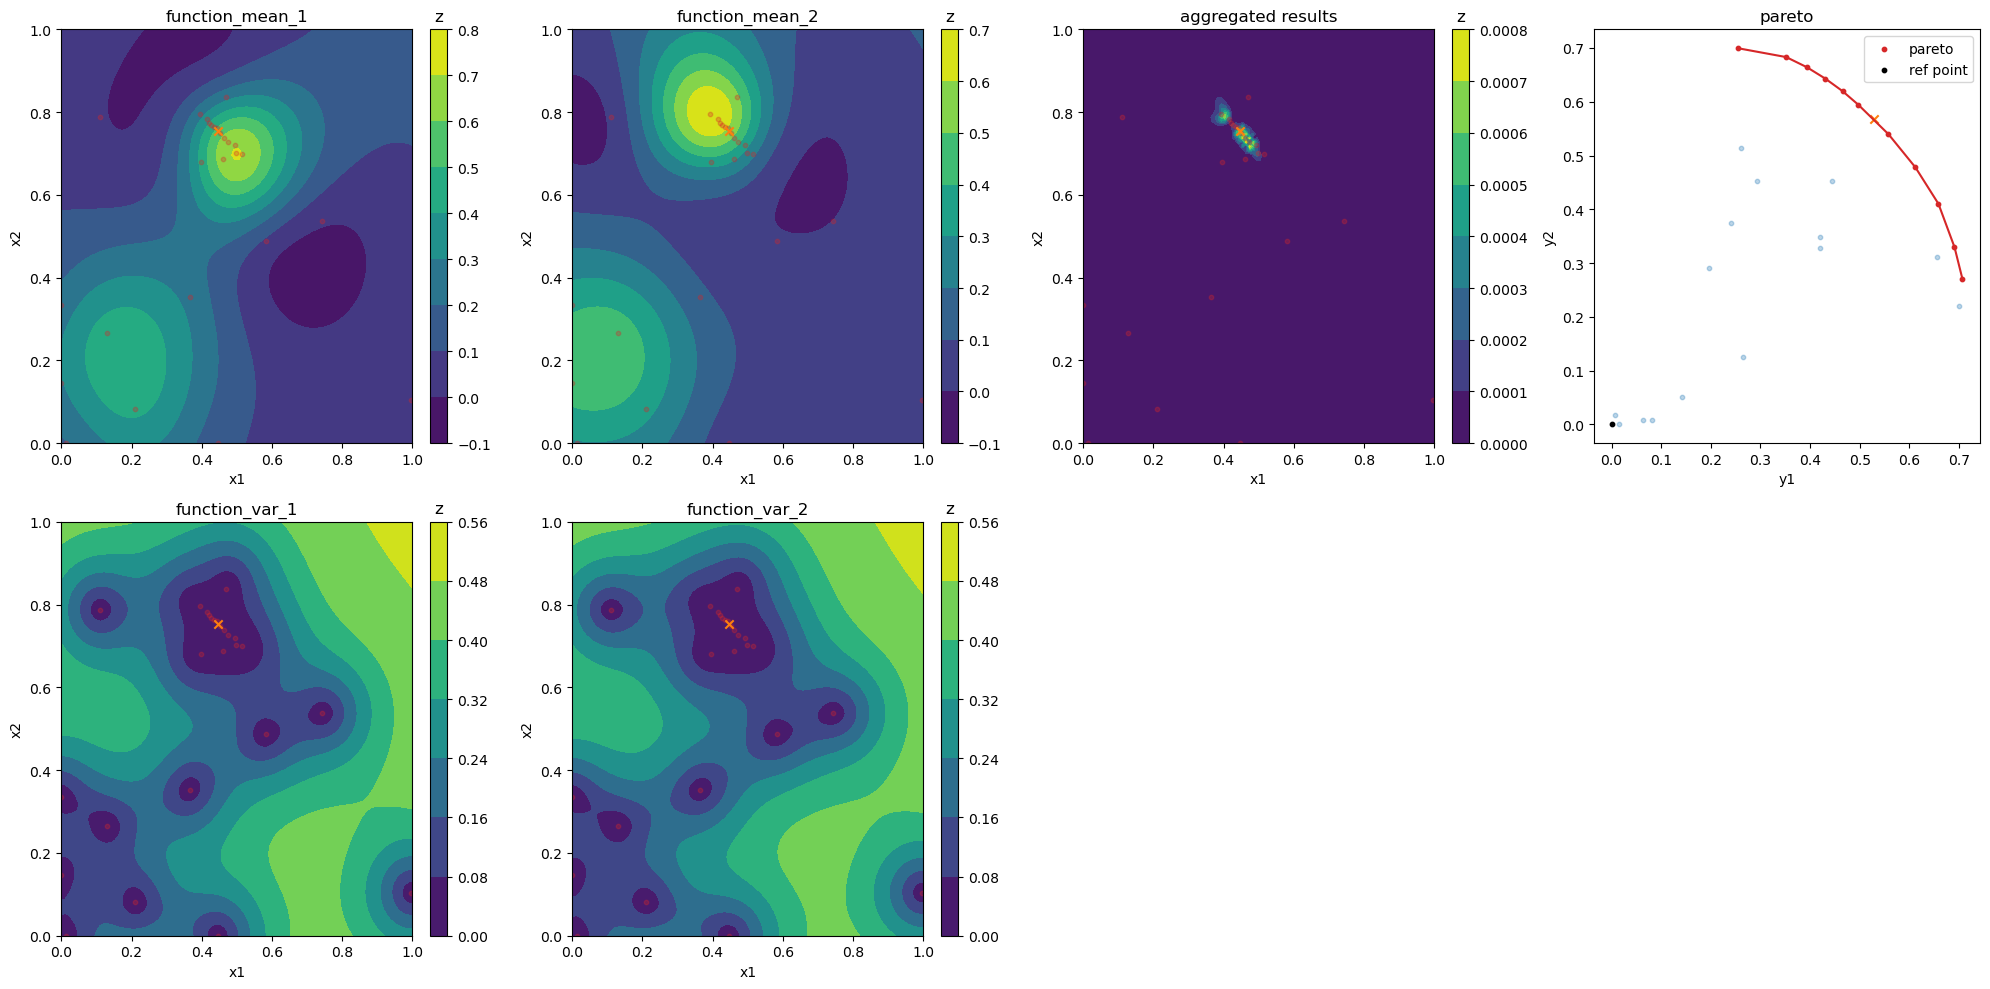

Iteration 21


2024-05-07 10:02:22,536 | Model fitting takes 0.38s
2024-05-07 10:02:23,177 | Optimizing the acquisition function takes 0.63s


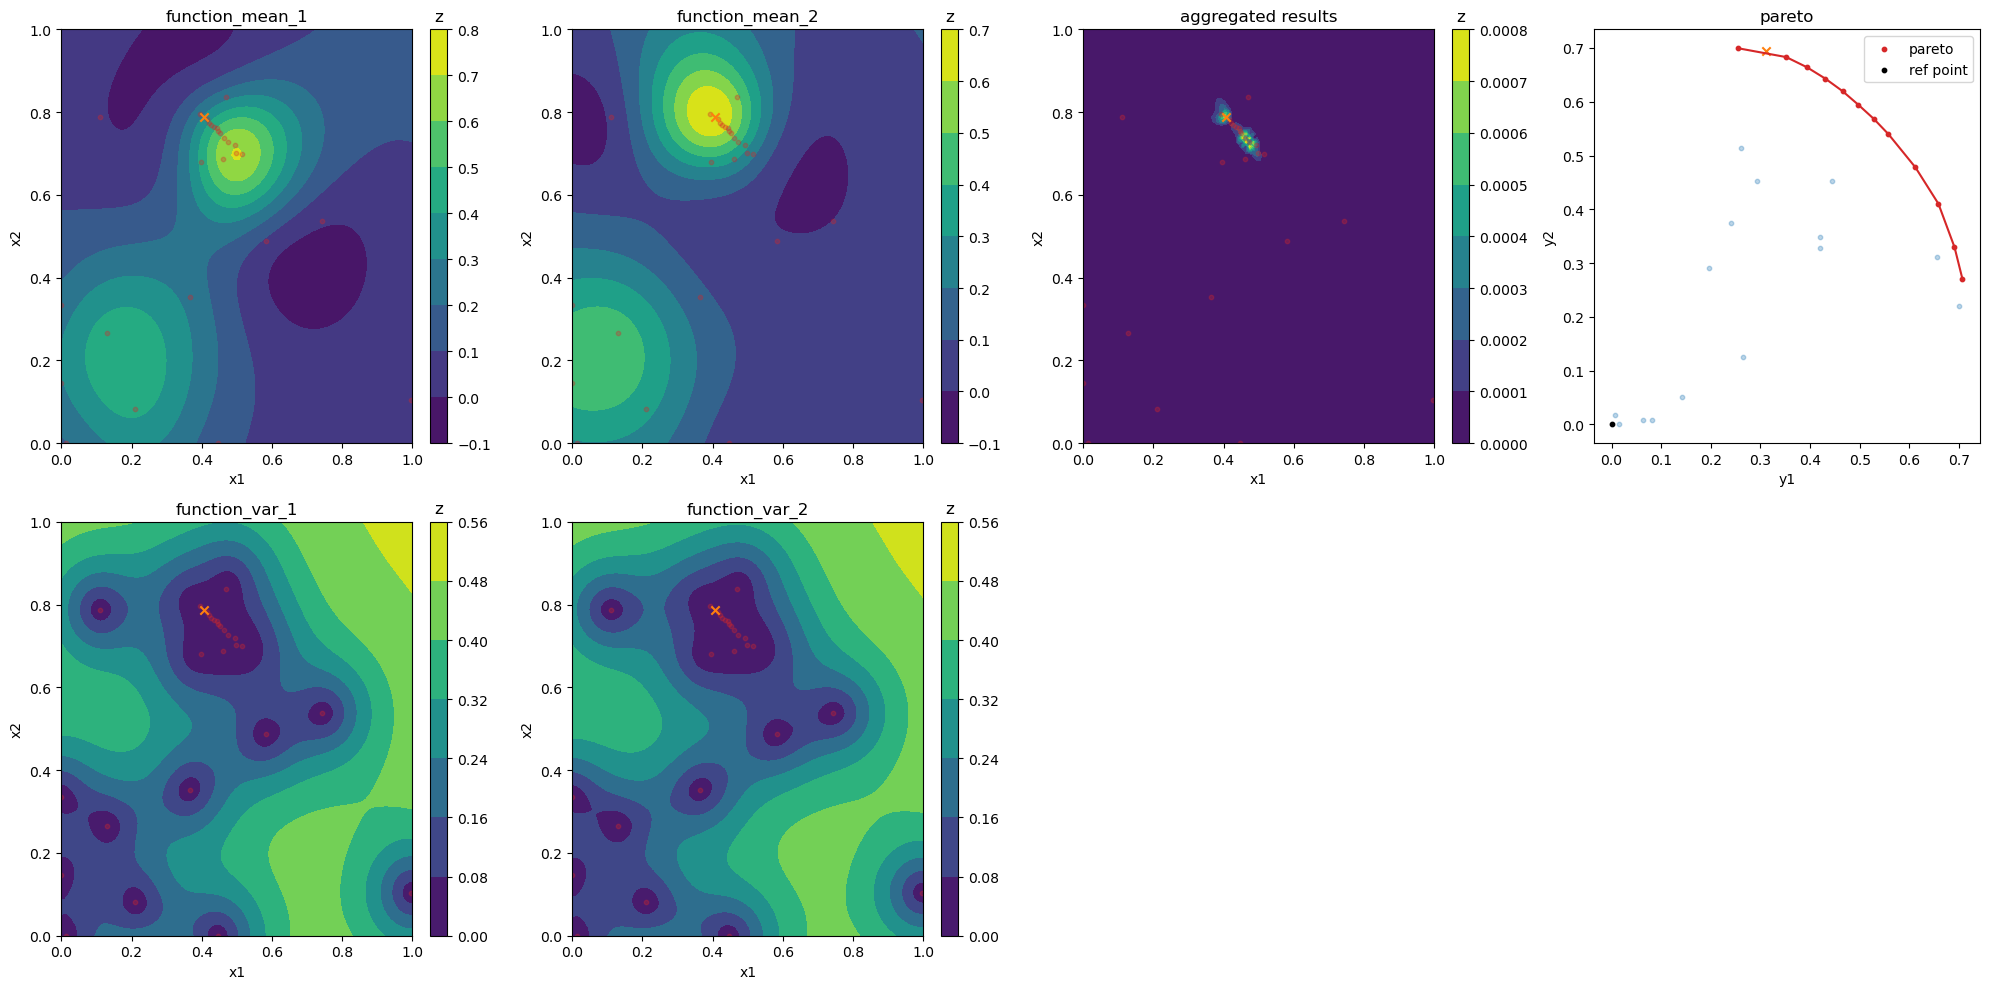

Iteration 22


2024-05-07 10:02:24,823 | Model fitting takes 0.24s
2024-05-07 10:02:25,717 | Optimizing the acquisition function takes 0.89s


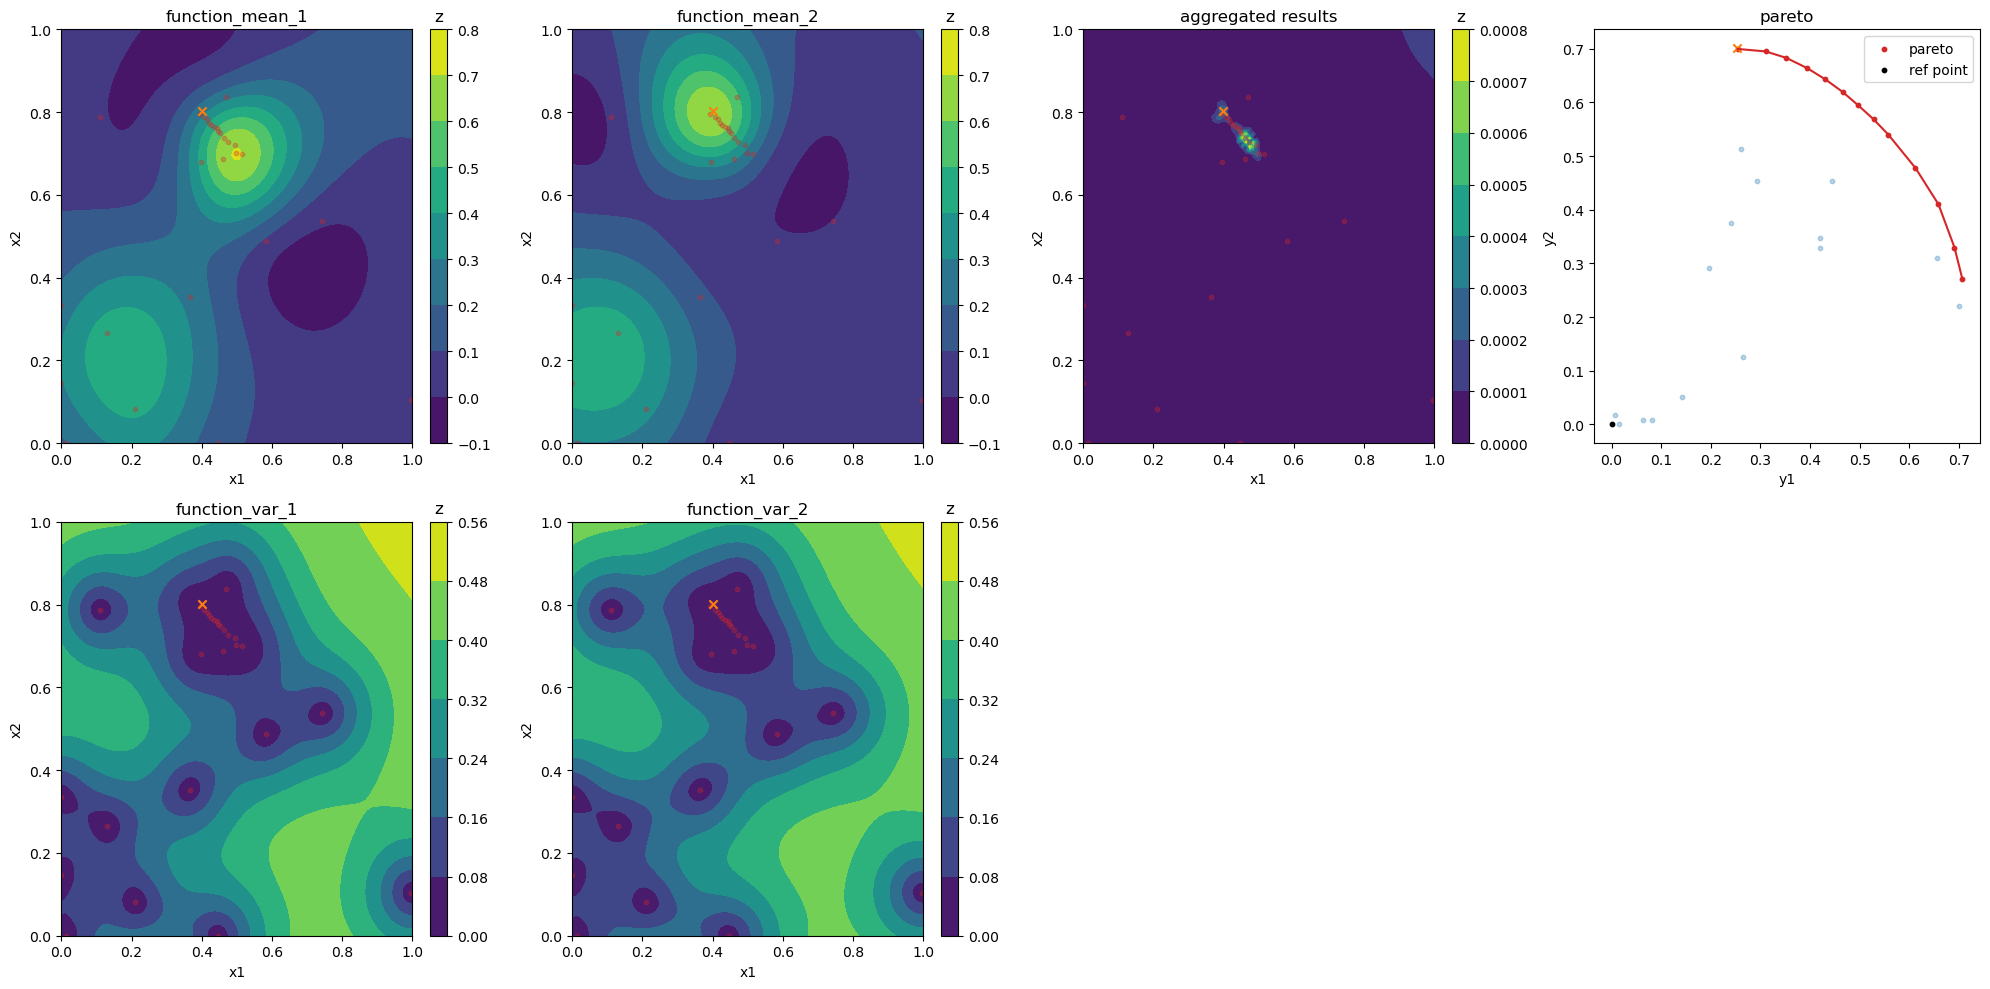

Iteration 23


2024-05-07 10:02:27,189 | Model fitting takes 0.25s
2024-05-07 10:02:27,859 | Optimizing the acquisition function takes 0.66s


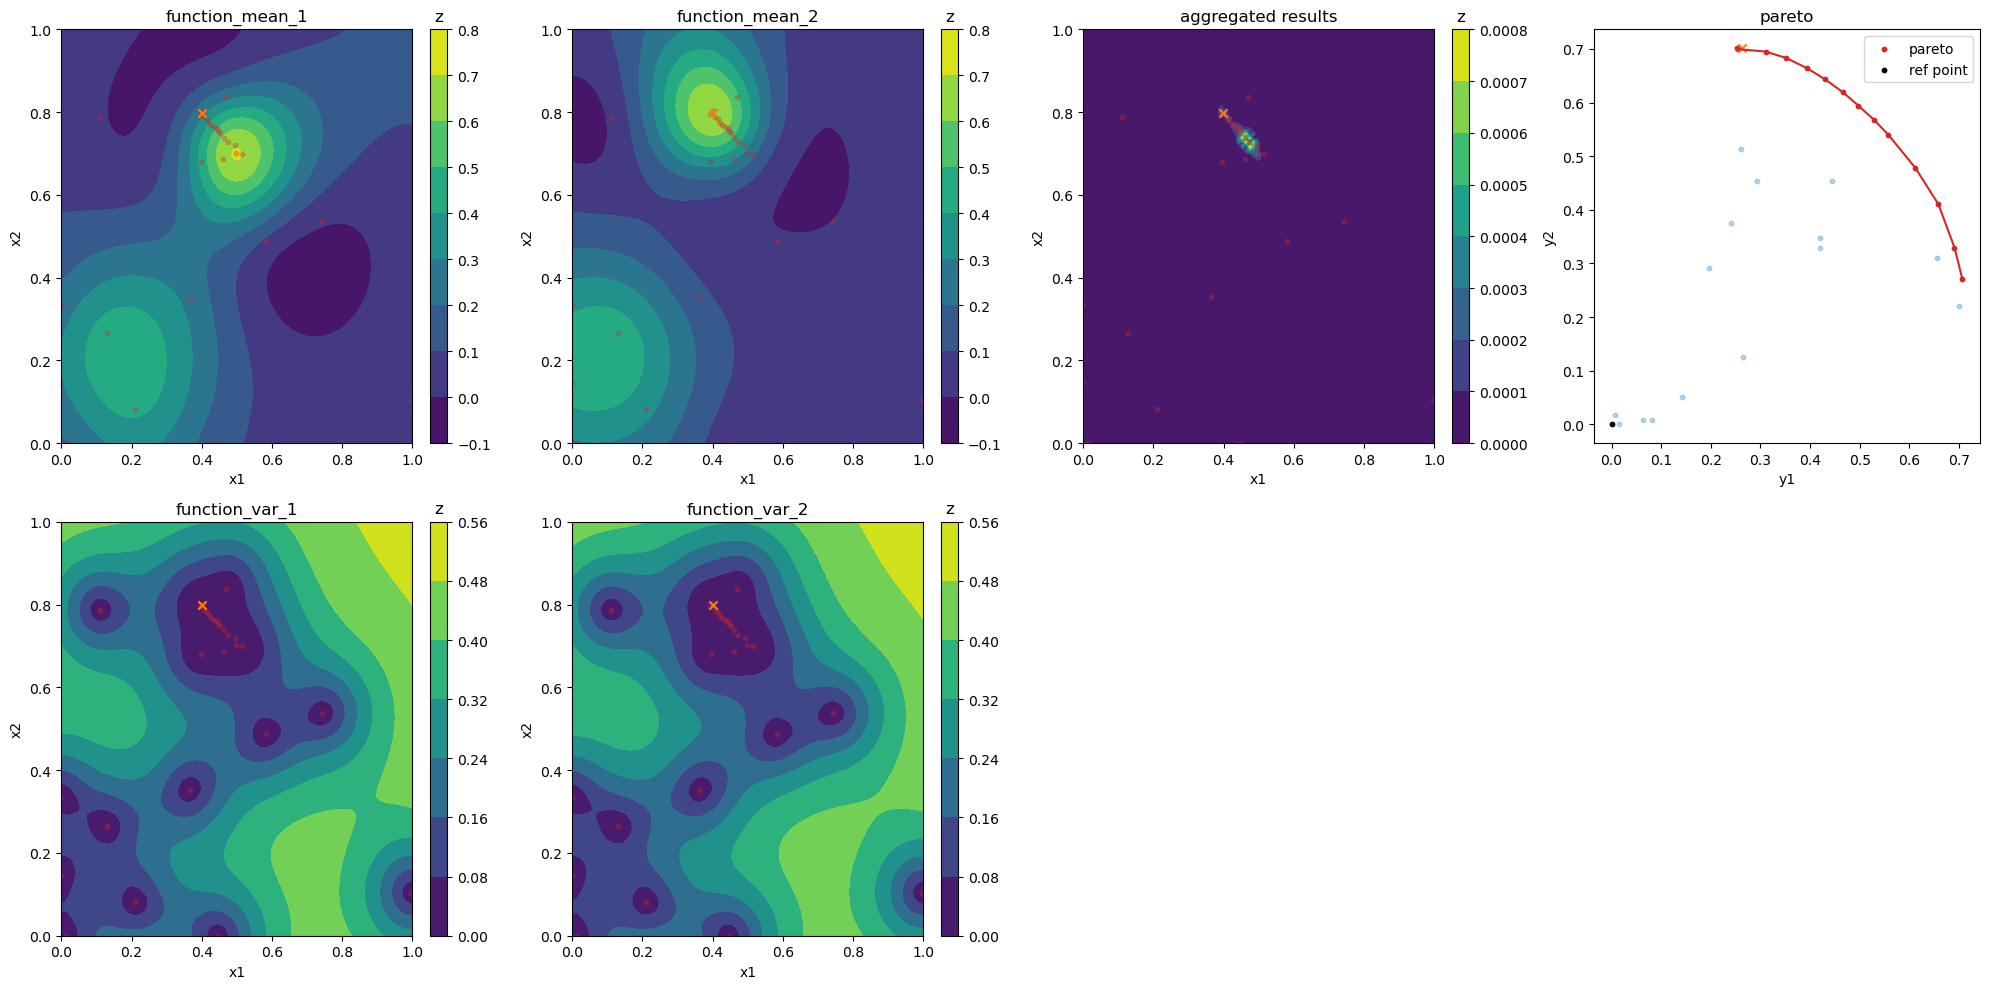

Iteration 24


2024-05-07 10:02:29,562 | Model fitting takes 0.32s
2024-05-07 10:02:30,407 | Optimizing the acquisition function takes 0.84s


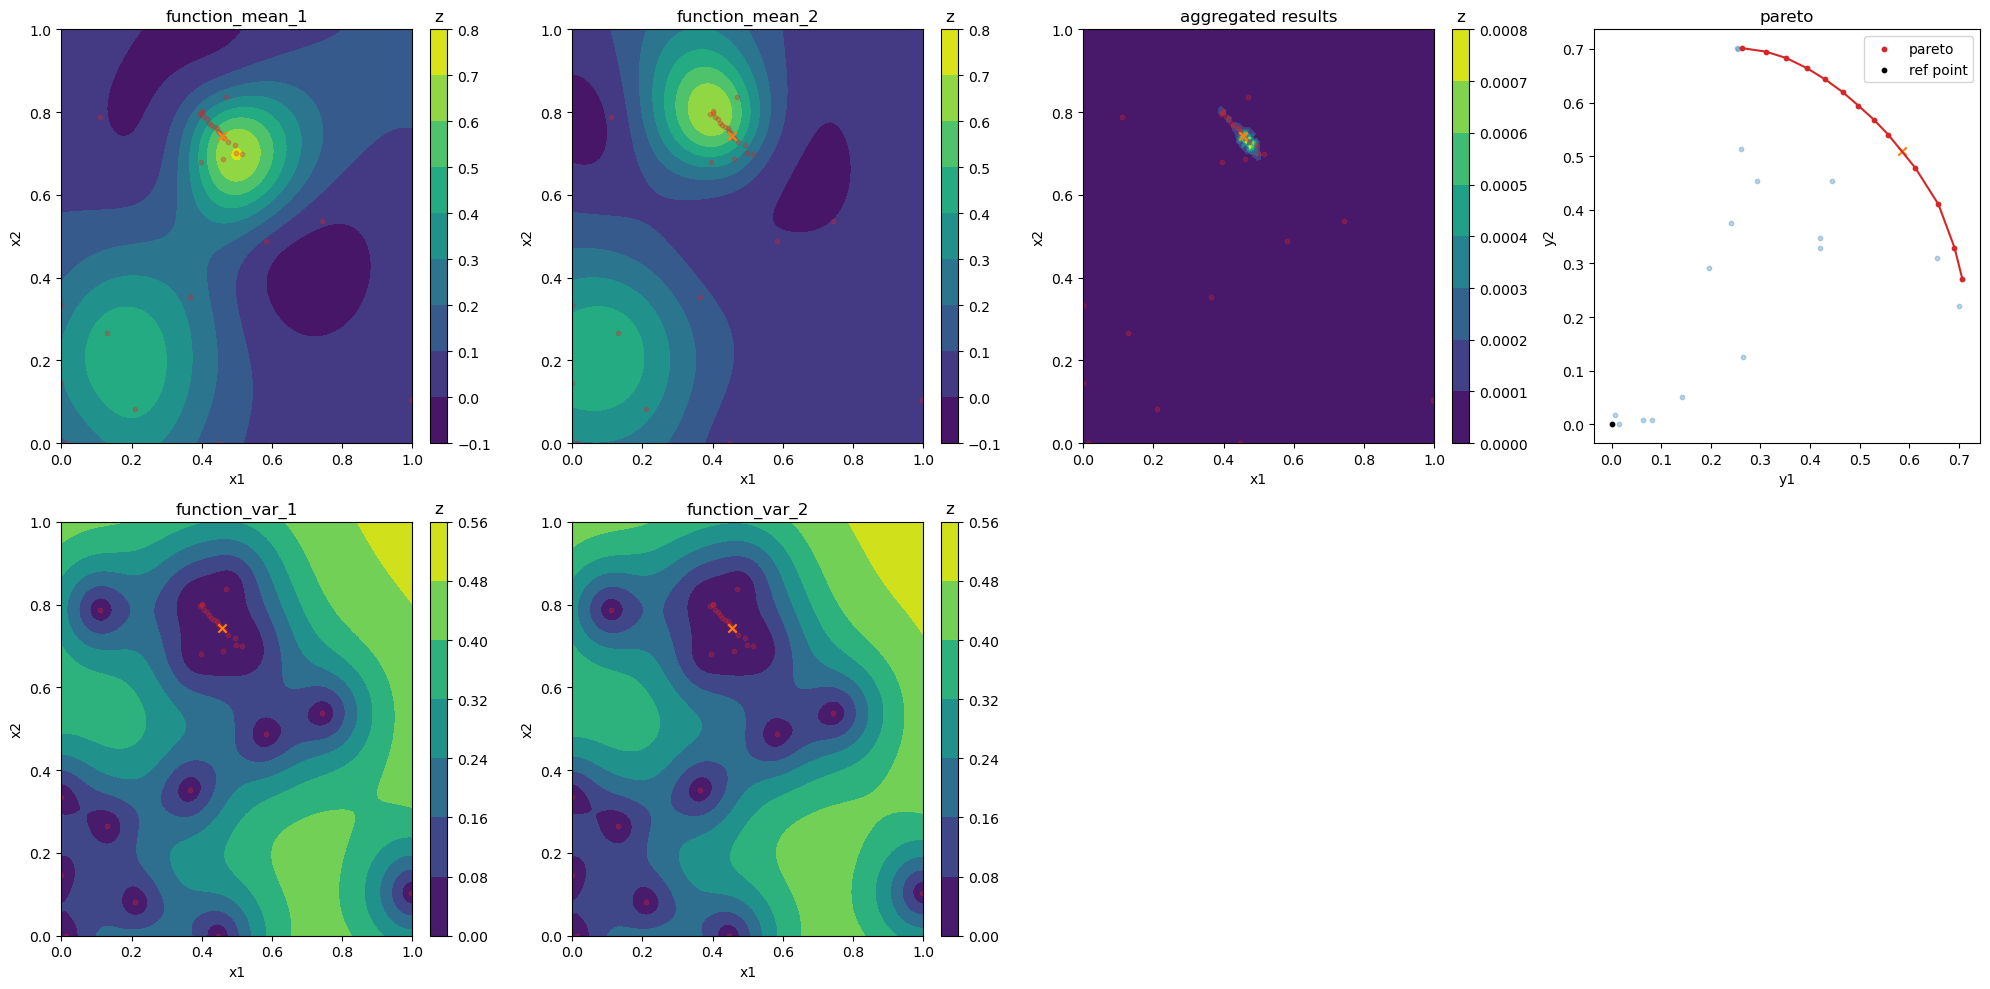

Iteration 25


2024-05-07 10:02:32,210 | Model fitting takes 0.58s
2024-05-07 10:02:33,466 | Optimizing the acquisition function takes 1.25s


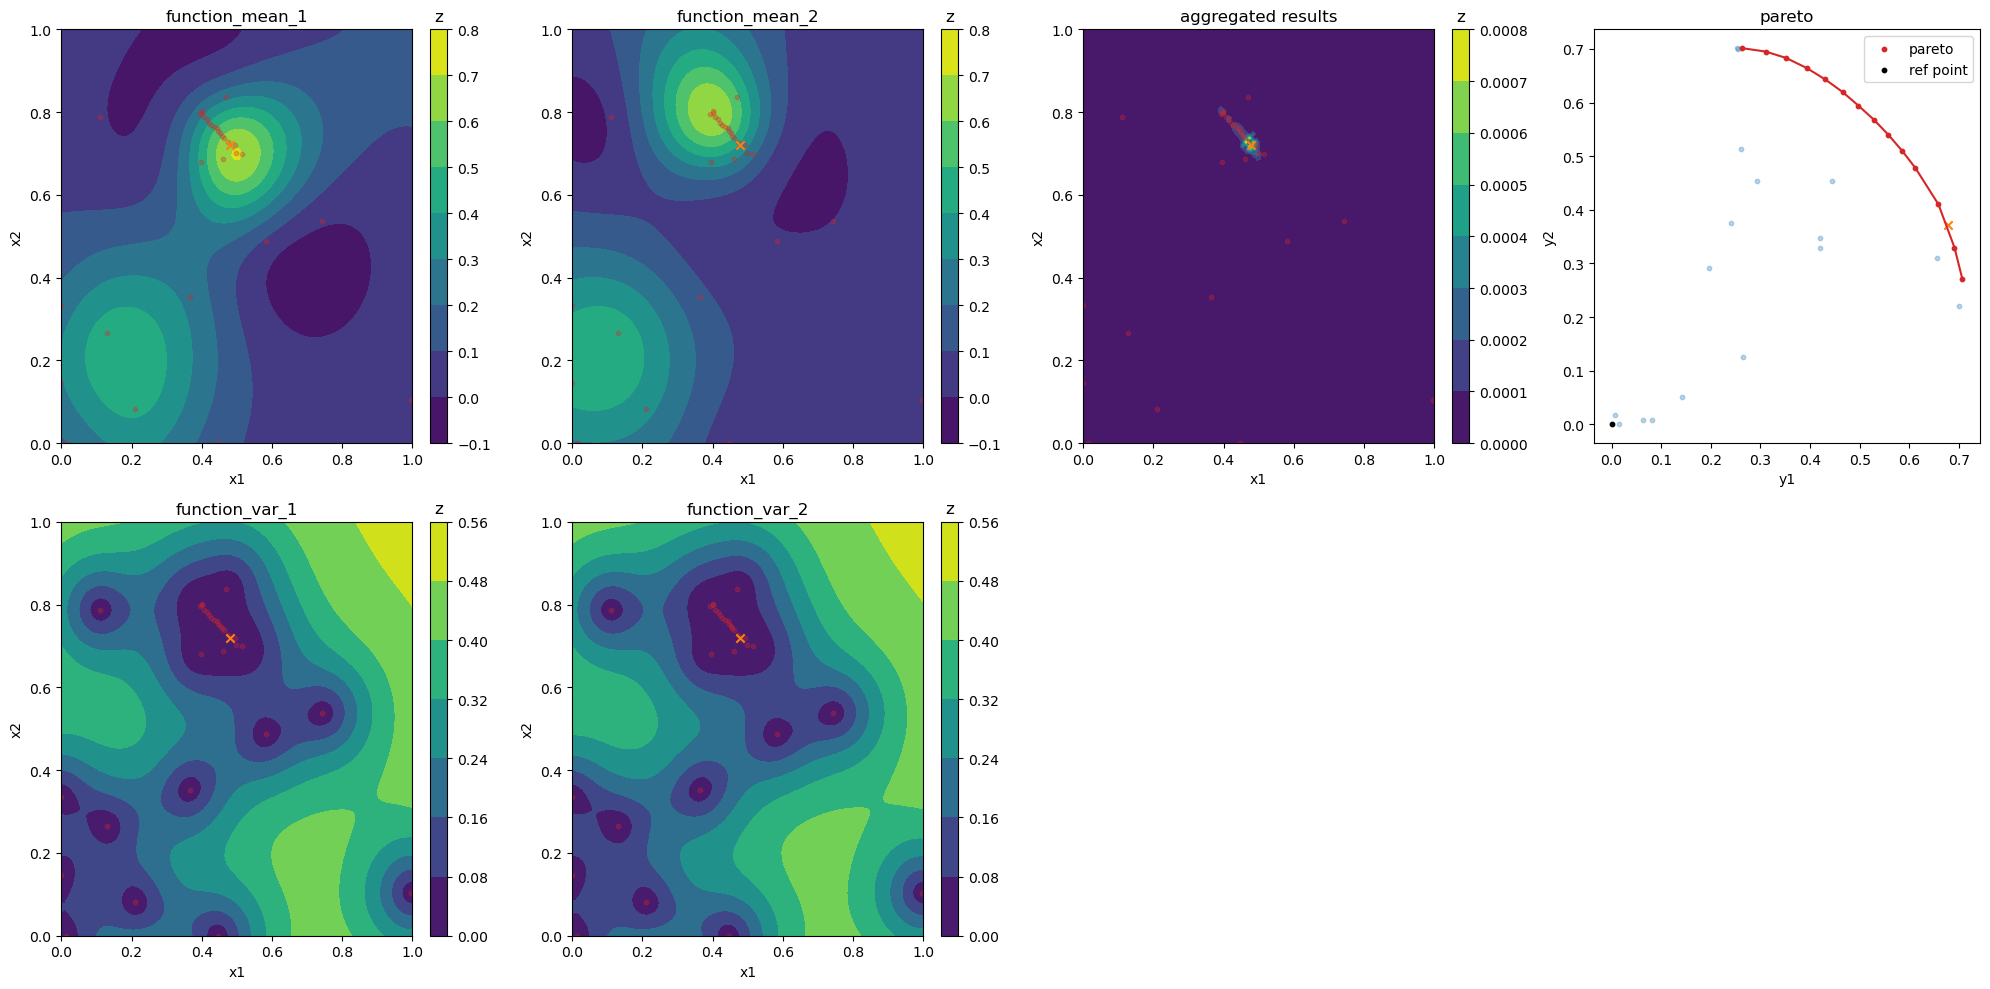

Iteration 26


2024-05-07 10:02:35,076 | Model fitting takes 0.37s
2024-05-07 10:02:35,795 | Optimizing the acquisition function takes 0.71s


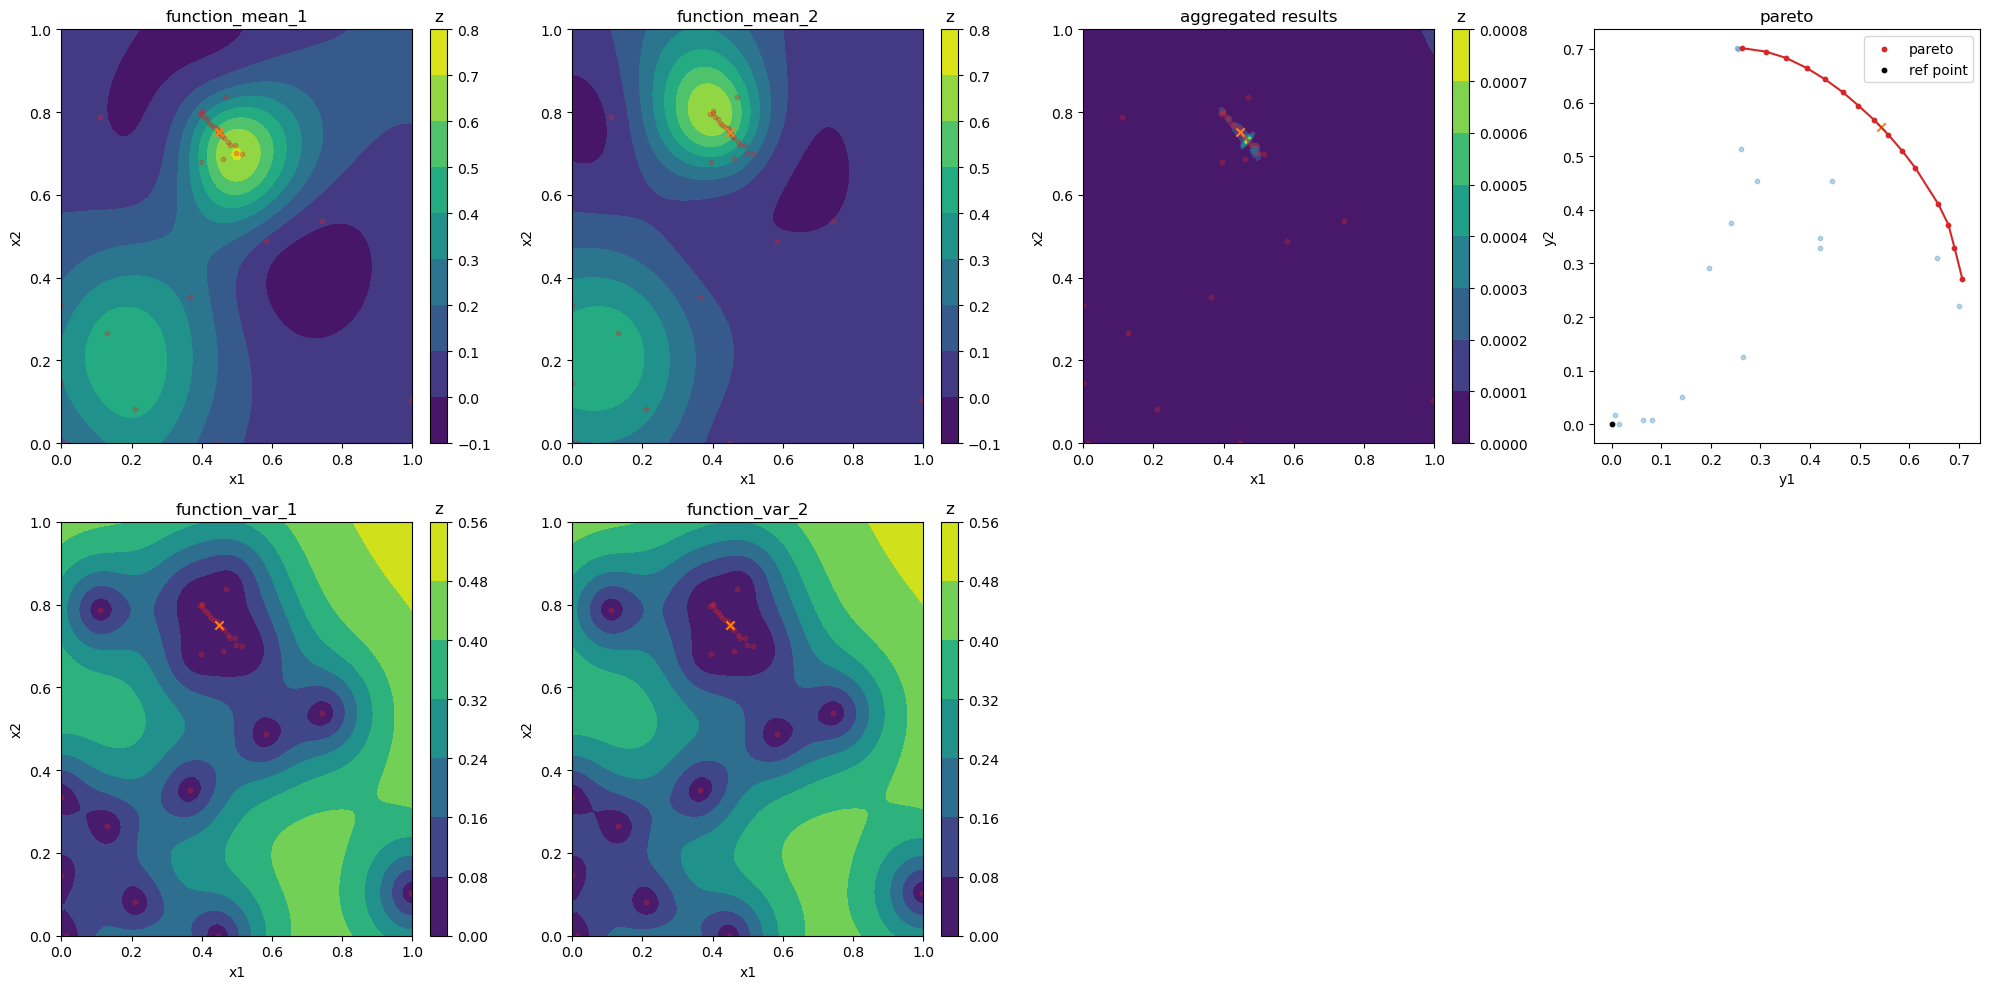

Iteration 27


2024-05-07 10:02:37,627 | Model fitting takes 0.42s
2024-05-07 10:02:38,386 | Optimizing the acquisition function takes 0.75s


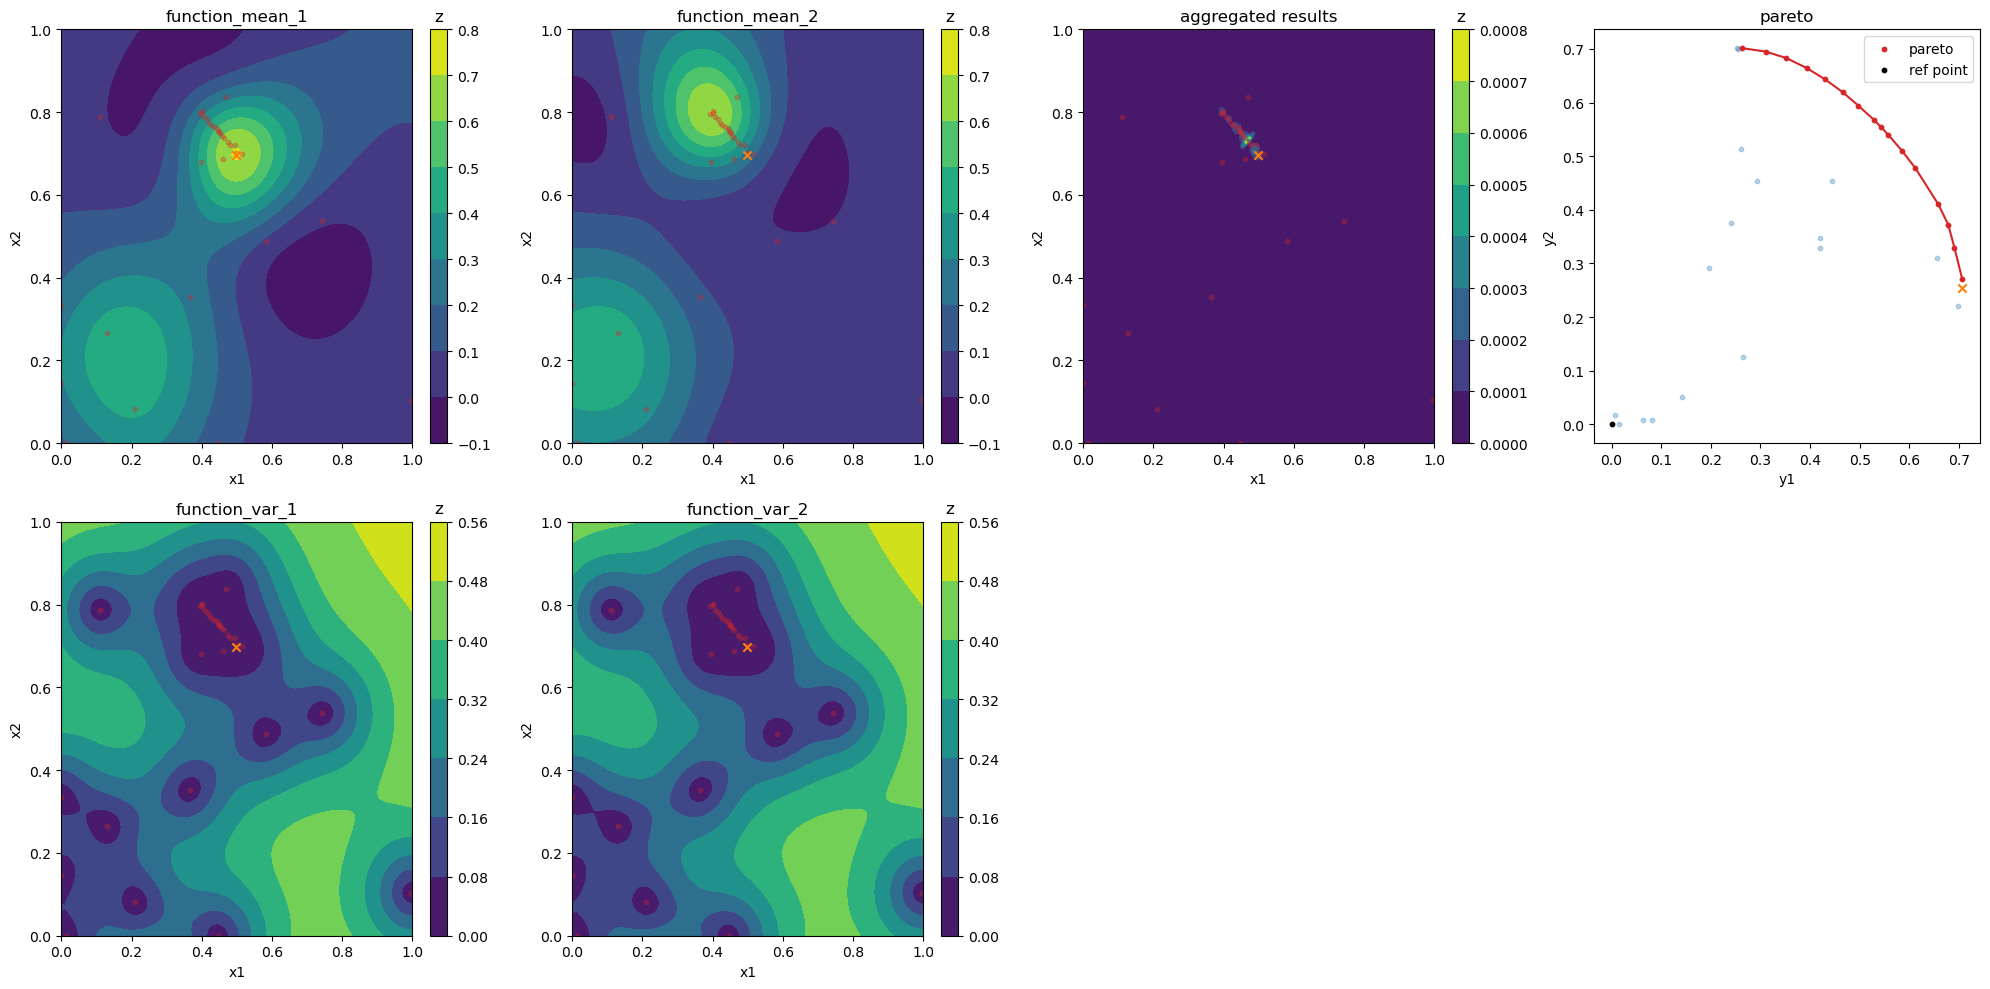

Iteration 28


2024-05-07 10:02:40,057 | Model fitting takes 0.41s
2024-05-07 10:02:40,597 | Optimizing the acquisition function takes 0.53s


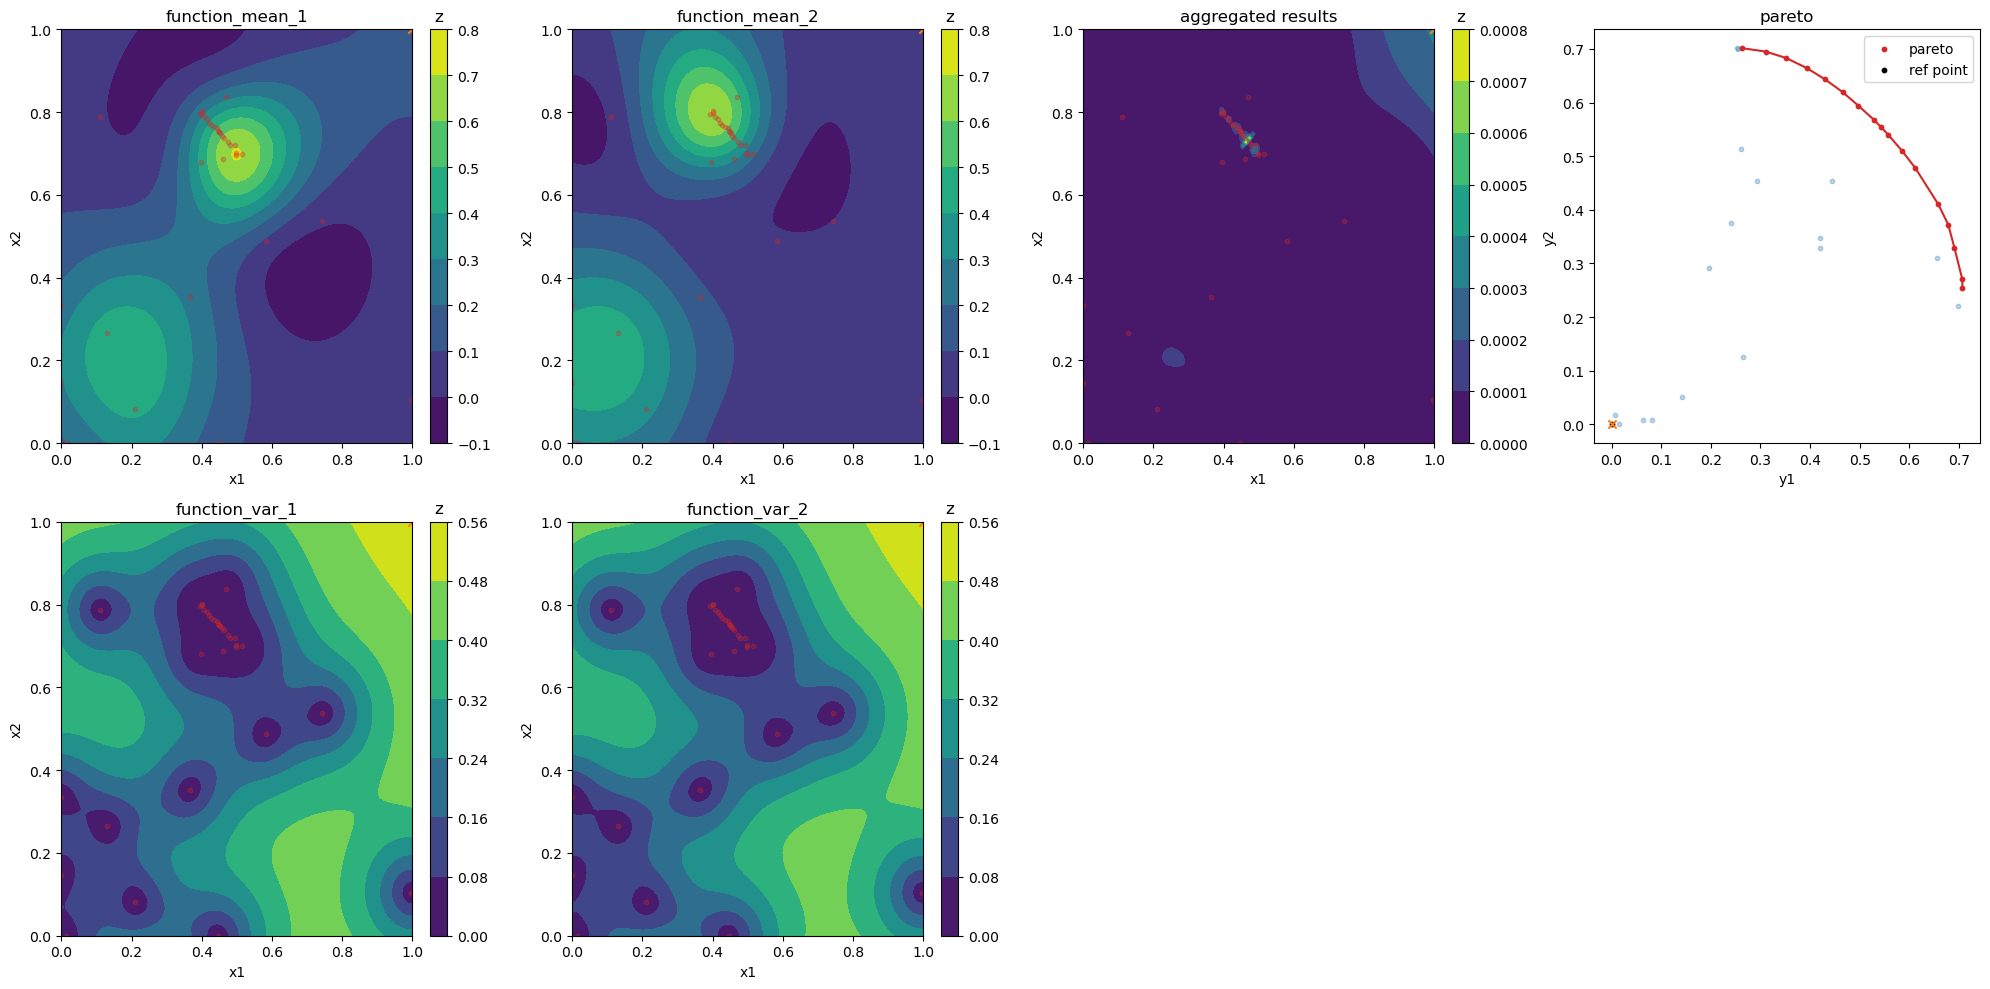

Iteration 29


2024-05-07 10:02:42,156 | Model fitting takes 0.31s
2024-05-07 10:02:43,207 | Optimizing the acquisition function takes 1.05s


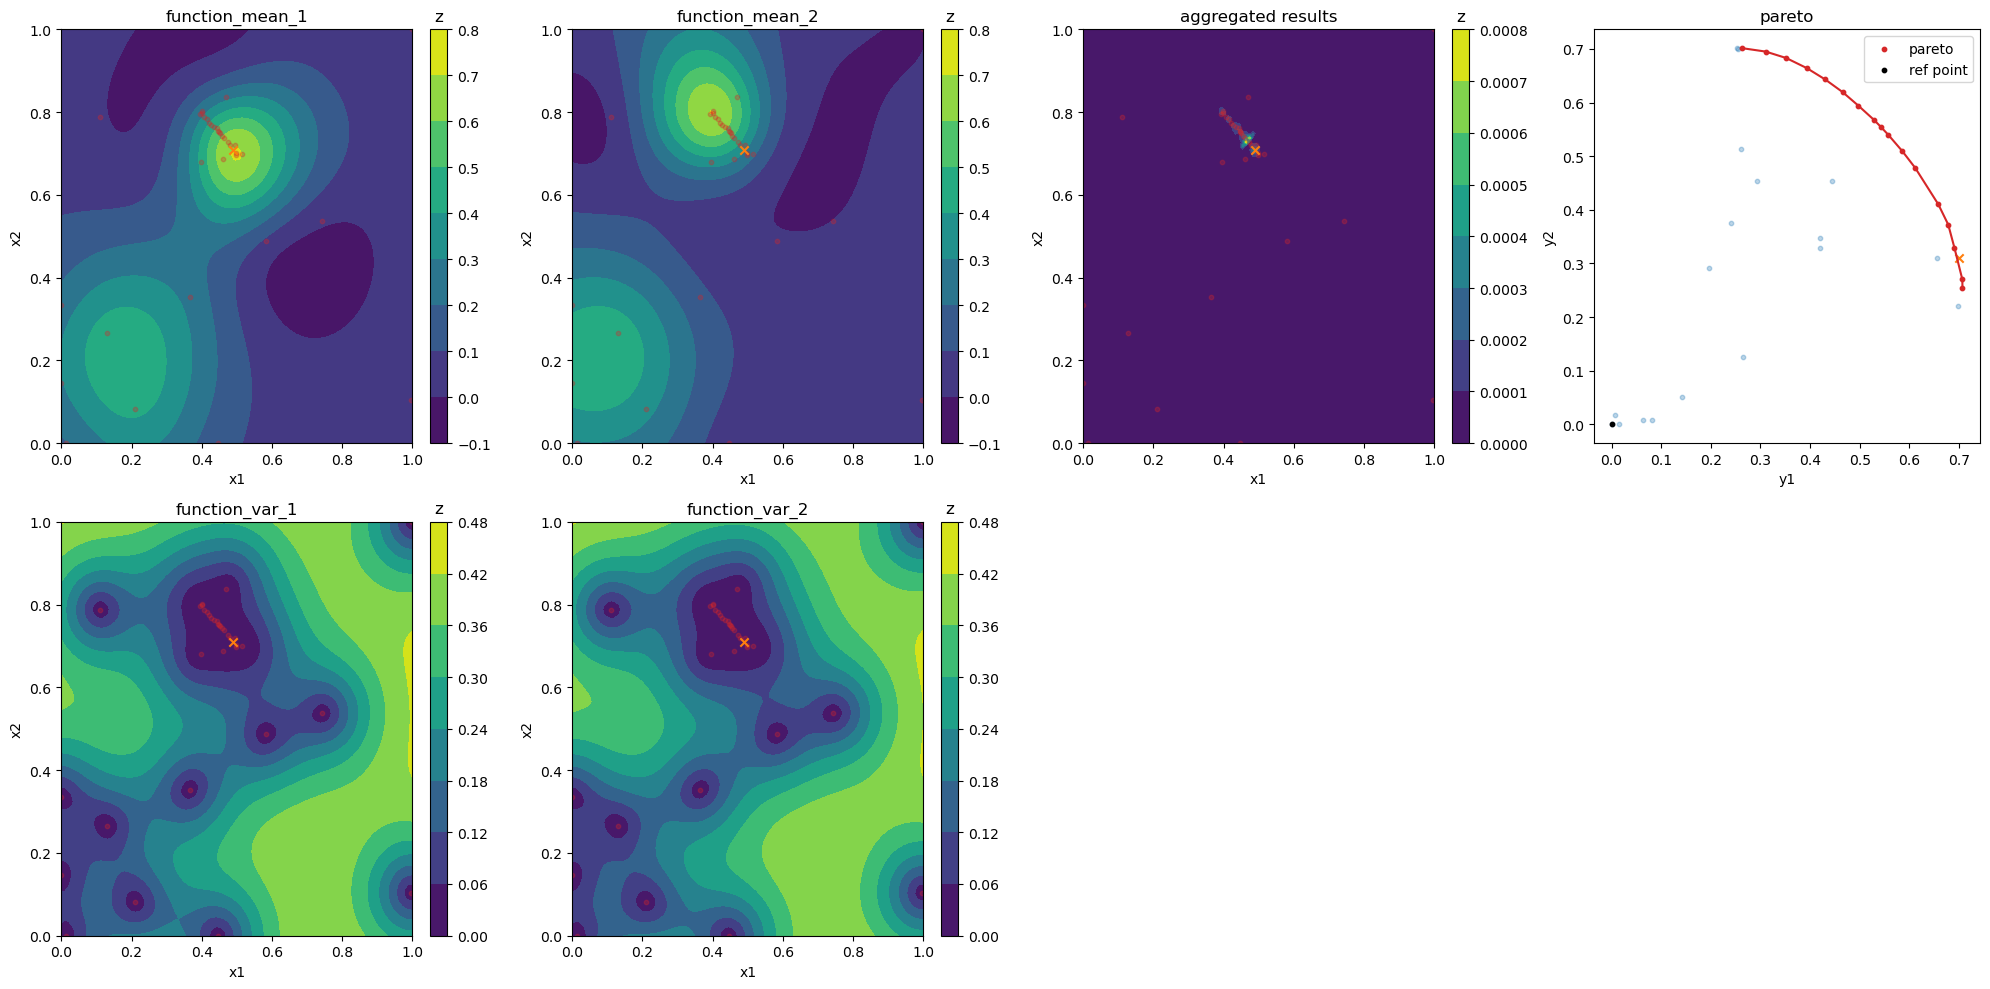

In [10]:
x_obs = init_x
y_obs = init_y

optimizer = qEHVI(
    problem=problem,
)

for n in range(30):
    print(f"Iteration {n}")

    pareto = is_non_dominated(y_obs)
    bd = DominatedPartitioning(ref_point=problem.ref_point, Y=y_obs)
    nbd = FastNondominatedPartitioning(ref_point=problem.ref_point, Y=y_obs)
    u, l = bd.hypercell_bounds
    u_nbd, _ = nbd.hypercell_bounds

    boxes = [Rectangle(
        l_point.cpu(),
        *(u_point - l_point).cpu(),
    ) for l_point, u_point in zip(l, u)]

    new_x = optimizer.observe_and_suggest(x_obs, y_obs)
    new_y = problem(new_x)

    with torch.no_grad():
        posterior = optimizer.model.posterior(x_cands)
        acq_func = optimizer.acq_func(x_cands.unsqueeze(1))
    # plot aggregated results
    fig = plt.figure(figsize=(20, 10))

    ax_func_mean_1 = plt.subplot2grid((2, 4), (0, 0))
    plot_input_space(xx, yy, x_obs, posterior.mean[:, 0], fig, ax_func_mean_1, title="function_mean_1")
    ax_func_mean_1.scatter(*new_x.t(), marker='x', color='tab:orange', label='candidates')
    ax_func_ci_1 = plt.subplot2grid((2, 4), (1, 0))
    plot_input_space(xx, yy, x_obs, 2*posterior.variance[:, 0].sqrt(), fig, ax_func_ci_1, title="function_var_1")
    ax_func_ci_1.scatter(*new_x.t(), marker='x', color='tab:orange', label='candidates')
    
    ax_func_mean_2 = plt.subplot2grid((2, 4), (0, 1))
    plot_input_space(xx, yy, x_obs, posterior.mean[:, 1], fig, ax_func_mean_2, title="function_mean_2")
    ax_func_mean_2.scatter(*new_x.t(), marker='x', color='tab:orange', label='candidates')
    ax_func_ci_2 = plt.subplot2grid((2, 4), (1, 1))
    plot_input_space(xx, yy, x_obs, 2*posterior.variance[:, 1].sqrt(), fig, ax_func_ci_2, title="function_var_2")
    ax_func_ci_2.scatter(*new_x.t(), marker='x', color='tab:orange', label='candidates')

    ax_agg = plt.subplot2grid((2, 4), (0, 2))
    plot_input_space(xx, yy, x_obs, acq_func, fig, ax_agg, title="aggregated results")
    ax_agg.scatter(*new_x.t(), marker='x', color='tab:orange', label='candidates')

    ax_agg_p = plt.subplot2grid((2, 4), (0, 3))
    plot_pareto_space(y_obs, pareto, l, u_nbd, ax_agg_p, title='pareto')
    ax_agg_p.scatter(*new_y.t(), marker='x', color='tab:orange', label='candidates')
    plt.tight_layout()
    plt.show()

    x_obs = torch.cat([x_obs, new_x])
    y_obs = torch.cat([y_obs, new_y])